In [1]:
from __future__ import print_function
import numpy as np
from skimage import io
from skimage import transform
import matplotlib.pyplot as plt
import os
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim  
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import argparse
import random
import torchvision.transforms.functional as TF

from torchvision.utils import save_image
from skimage.util import random_noise
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix 
import kornia.augmentation.functional as FF

In [2]:
root = "./"
def default_loader(path):
    return Image.open(path).convert('RGB')

In [3]:
class MyDataset(torch.utils.data.Dataset): 
    def __init__(self,root, datatxt, transform=None, target_transform=None,loader=default_loader):
        super(MyDataset,self).__init__()
        fh = open(root + datatxt, 'r') 
        imgs = []     
        data = []
        label = []
        for line in fh:                
            line = line.rstrip()       
            data.append(line)
        for line in range(len(data)-1):
            words = data[line].split()  
            imgs.append((words[0])) 
            label.append(int(words[1]))
            
        
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform
        self.label = torch.LongTensor(label)
 
    # def __getitem__(self, index):    
    def __getitem__(self, idx):    
        image = Image.open(str(self.imgs[idx]))
        # image = image.convert('RGB')
        image = image.convert('L')
        if self.transform is not None:
            image = self.transform(image)
        label = self.label[idx]
        return image, label
    def __len__(self): 
        return len(self.imgs)

In [4]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [5]:
train_dataset = MyDataset(root='./',datatxt='train.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
trainNew_dataset = MyDataset(root='./',datatxt='train-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
test_dataset = MyDataset(root='./',datatxt='test.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
testNew_dataset = MyDataset(root='./',datatxt='test-new.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
origin_dataset = MyDataset(root='./',datatxt='origin.txt', transform=transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,)),
#         AddGaussianNoise(0., 0.05)
        ]))
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True,num_workers=1)
trainNew_loader = DataLoader(dataset=trainNew_dataset, batch_size=64, shuffle=True,num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False,num_workers=1)
testNew_loader = DataLoader(dataset=testNew_dataset, batch_size=64, shuffle=False,num_workers=1)
origin_loader = DataLoader(dataset=origin_dataset, batch_size=64, shuffle=False,num_workers=1)
print('num_of_trainData:', len(train_dataset))
print('num_of_trainNewData:', len(trainNew_dataset))
print('num_of_testData:', len(test_dataset))
print('num_of_testNewData:', len(testNew_dataset))
print('num_of_originData:', len(origin_dataset))

num_of_trainData: 71432
num_of_trainNewData: 89827
num_of_testData: 8141
num_of_testNewData: 10299
num_of_originData: 8141


label： tensor(0) shape: (1, 19, 19)
<class 'numpy.ndarray'>


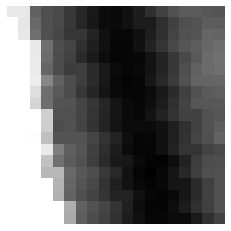

In [6]:
import matplotlib
idx = 11
img = test_dataset[idx][0].numpy()
plt.imshow(img[0], cmap = 'gray')
plt.imsave('test.png', img[0], cmap = 'gray')
# figure, b = plt.subplots()
# figure.set_size_inches(0.19, 0.19)
plt.axis('off') 
print('label：',train_dataset[idx][1], 'shape:', img.shape)
print(type(img[0]))
matplotlib.image.imsave('name.png',img[0])

In [7]:
positive = 0
negative = 0
for idx in range(1,71432):
    if train_dataset[idx][1].item() == 0:
        negative = negative+1
    else:
        positive = positive+1
print('negative: ', negative)
print('positive: ', positive)

negative:  36885
positive:  34546


In [11]:
class GaborConvPC(nn.Module):
    def __init__(self, kernel_size, in_channels, num_orientations, num_scales):
        super(GaborConvPC, self).__init__()
        self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, self.bias1, self.weights1, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
        self.sigma2, self.theta2, self.Lambda2, self.psi2, self.gamma2, self.bias2, self.weights2, self.w, self.b = self.generate_parameters(num_orientations*num_scales, in_channels)
        # self.filter1 = self.whole_filter(in_channels, channel1, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1)
        self.filter_cos = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, True)
        self.filter_sin = self.whole_filter(in_channels, num_orientations, num_scales, kernel_size, self.sigma1, self.theta1, self.Lambda1, self.psi1, self.gamma1, False)
    
            
        
        self.fc1 = nn.Linear(1*1*48, 24)
        self.fc2 = nn.Linear(24, 2)



    def forward(self, x):
        x_cos = F.conv2d(x, self.filter_cos, bias=self.bias1)
        x_sin = F.conv2d(x, self.filter_sin, bias=self.bias2)
        x_comb = torch.cat((x_cos, x_sin), 2)
#         print("ken",len(x))
#         print("x_comb size", x_comb.size())
#         x_comb = F.max_pool2d(x_comb, 2, 2)
#         x_comb = F.relu(self.conv(x_comb))
#         x_comb = F.max_pool2d(x_comb, 2, 2)
#         bbb = torch.abs(torch.tensor([-1, -2, 3]))
        x_cos = x_cos.view(len(x), 1, 1, 48)
        x_sin = x_sin.view(len(x), 1, 1, 48)
        weighted_cos = (torch.matmul(x_cos, self.weights1)).view(len(x), 1)
        weighted_sin = (torch.matmul(x_sin, self.weights1)).view(len(x), 1)

        numerator = torch.norm(torch.cat([weighted_cos, weighted_sin], 1), dim=1)
#         print("numerator", numerator.size())
        x_comb_norm = torch.norm(x_comb, dim=2)
        x_comb_norm = x_comb_norm.view(len(x), 1, 48)
#         print("x_comb_norm", x_comb_norm.size())
        denominator = torch.matmul(x_comb_norm, torch.abs(self.weights1))
        denominator = denominator.view(len(x))
#         print("size:", numerator.size(), denominator.size())
        pc = numerator / denominator                
#         x_comb = x_comb.view(-1, 1*1*48)
#         x_comb = F.relu(self.fc1(x_comb))
#         x_comb = self.fc2(x_comb)
        return denominator, pc, torch.sigmoid(self.w * pc + self.b)


    def generate_parameters(self, dim_out, dim_in):
        sigma = nn.Parameter(torch.randn(1, 1))
        theta = nn.Parameter(torch.randn(1, 1))
        Lambda = nn.Parameter(torch.randn(1, 1))
        psi = nn.Parameter(torch.randn(1, 1))
        gamma = nn.Parameter(torch.randn(1, 1))
        bias = nn.Parameter(torch.randn(dim_out))
#         bias2 = nn.Parameter(torch.randn(dim_out))
        weights = nn.Parameter(torch.randn(1, 48, 1))
        w = nn.Parameter(torch.randn(1, 1))
        b = nn.Parameter(torch.randn(1, 1))
        return sigma, theta, Lambda, psi, gamma, bias, weights, w, b


    def whole_filter(self, in_channels, num_orientations, num_scales, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(num_orientations*num_scales, in_channels, kernel_size, kernel_size) # \text{out\_channels} , \frac{\text{in\_channels}}{\text{groups}} , kH , kW
        for i in range(num_orientations):
            for j in range(num_scales):
                result[i*num_scales + j] = self.one_filter(in_channels, kernel_size, sigma[0]*(2.1**j), theta[0]+i*np.pi/num_orientations, Lambda[0], psi[0], gamma[0], cos)
        return nn.Parameter(result)


    def one_filter(self, in_channels, kernel_size, sigma, theta, Lambda, psi, gamma, cos):
        result = torch.zeros(in_channels, kernel_size, kernel_size)
        for i in range(in_channels):
            result[i] = self.gabor_fn(sigma, theta, Lambda, psi, gamma, kernel_size, cos)
        return nn.Parameter(result)


#     def gabor_fn(self, sigma, theta, Lambda, psi, gamma, kernel_size, cos):
#         sigma_x = sigma
#         # sigma_y = float(sigma) / gamma
#         sigma_y = sigma / gamma

#         # Bounding box
#         half_size = (kernel_size - 1) // 2
#         ymin, xmin = -half_size, -half_size
#         ymax, xmax = half_size, half_size
#         (x, y) = np.meshgrid(np.arange(xmin, xmax + 1), np.arange(ymin, ymax + 1))
#         y = torch.FloatTensor(y)
#         x = torch.FloatTensor(x)

#         # Rotation
#         x_theta = x * torch.cos(theta) + y * torch.sin(theta)
#         y_theta = -x * torch.sin(theta) + y * torch.cos(theta)


#         if cos:
#             gb = torch.exp((-1*(x_theta*x_theta+y_theta*y_theta*gamma*gamma))/(2*sigma*sigma))* torch.cos(2 * np.pi / Lambda * x_theta + psi)
#         else:
#             gb = torch.exp((-1*(x_theta*x_theta+y_theta*y_theta*gamma*gamma))/(2*sigma*sigma))* torch.sin(2 * np.pi / Lambda * x_theta + psi)
#         return gb
    def gabor_fn(self, sigma, theta, Lambda, psi, gamma, kernel_size, cos):
        sigma_x = sigma
        # sigma_y = float(sigma) / gamma
        sigma_y = sigma / gamma

        # Bounding box
        half_size = (kernel_size - 1) // 2
        ymin, xmin = -half_size, -half_size
        ymax, xmax = half_size, half_size
    #     (y, x) = np.meshgrid(np.arange(ymin, ymax + 1), np.arange(xmin, xmax + 1))
        y, x = torch.meshgrid([torch.arange(ymin, ymax+1), torch.arange(xmin,xmax+1)])

        if cos:
            gb = torch.exp(-.5 * (x**2 / sigma_x**2 + y**2 / sigma_y**2)) * torch.cos(2 * np.pi / Lambda * x + psi)
        else:
            gb = torch.exp(-.5 * (x**2 / sigma_x**2 + y**2 / sigma_y**2)) * torch.sin(2 * np.pi / Lambda * x + psi)

        # Rotation
        degrees = theta * 180 / np.pi
        gb = FF.apply_rotation(gb, {'degrees': torch.tensor(degrees)}, {'interpolation': torch.tensor([1]), 'align_corners': torch.tensor(True)})
        gb = gb.squeeze()
        return gb


<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([48])
<class 'torch.Tensor'> torch.Size([1, 48, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([1, 1])
<class 'torch.Tensor'> torch.Size([48])
<class 'torch.Tensor'> torch.Size([1, 48, 1])
<class 'torch.Tensor'> torch.Size([48, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([48, 1, 19, 19])
<class 'torch.Tensor'> torch.Size([24, 48])
<class 'torch.Tensor'> torch.Size([24])
<class 'torch.Tensor'> torch.Size([2, 24])
<class 'torch.Tensor'> torch.Size([2])


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Train Epoch: 1 [0/71432 (0%)]	Loss: 45.632061
Train Epoch: 1 [6400/71432 (9%)]	Loss: 25.603024
Train Epoch: 1 [12800/71432 (18%)]	Loss: 12.675219
Train Epoch: 1 [19200/71432 (27%)]	Loss: 17.805130
Train Epoch: 1 [25600/71432 (36%)]	Loss: 17.625599
Train Epoch: 1 [32000/71432 (45%)]	Loss: 11.047929
Train Epoch: 1 [38400/71432 (54%)]	Loss: 6.260323
Train Epoch: 1 [44800/71432 (63%)]	Loss: 16.086739
Train Epoch: 1 [51200/71432 (72%)]	Loss: 13.747988
Train Epoch: 1 [57600/71432 (81%)]	Loss: 18.033253
Train Epoch: 1 [64000/71432 (90%)]	Loss: 18.599098
Train Epoch: 1 [70400/71432 (98%)]	Loss: 17.898638

Test set: Average loss: 0.2377, Accuracy: 7444/8141 (91%), Positive accuracy: 3462/4091 (85%), Negative accuracy: 3982/4050 (98%)

Train Epoch: 2 [0/71432 (0%)]	Loss: 11.421661
Train Epoch: 2 [6400/71432 (9%)]	Loss: 20.248634
Train Epoch: 2 [12800/71432 (18%)]	Loss: 7.727456
Train Epoch: 2 [19200/71432 (27%)]	Loss: 15.339526
Train Epoch: 2 [25600/71432 (36%)]	Loss: 5.465788
Train Epoch: 2 [32

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:140: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Train Epoch: 10 [0/71432 (0%)]	Loss: 9.777493
Train Epoch: 10 [6400/71432 (9%)]	Loss: 6.443731
Train Epoch: 10 [12800/71432 (18%)]	Loss: 12.725603
Train Epoch: 10 [19200/71432 (27%)]	Loss: 3.636681
Train Epoch: 10 [25600/71432 (36%)]	Loss: 6.800249
Train Epoch: 10 [32000/71432 (45%)]	Loss: 6.816820
Train Epoch: 10 [38400/71432 (54%)]	Loss: 6.981023
Train Epoch: 10 [44800/71432 (63%)]	Loss: 7.255374
Train Epoch: 10 [51200/71432 (72%)]	Loss: 10.205438
Train Epoch: 10 [57600/71432 (81%)]	Loss: 8.209351
Train Epoch: 10 [64000/71432 (90%)]	Loss: 6.842168
Train Epoch: 10 [70400/71432 (98%)]	Loss: 8.644842

Test set: Average loss: 0.1470, Accuracy: 7692/8141 (94%), Positive accuracy: 3718/4091 (91%), Negative accuracy: 3974/4050 (98%)



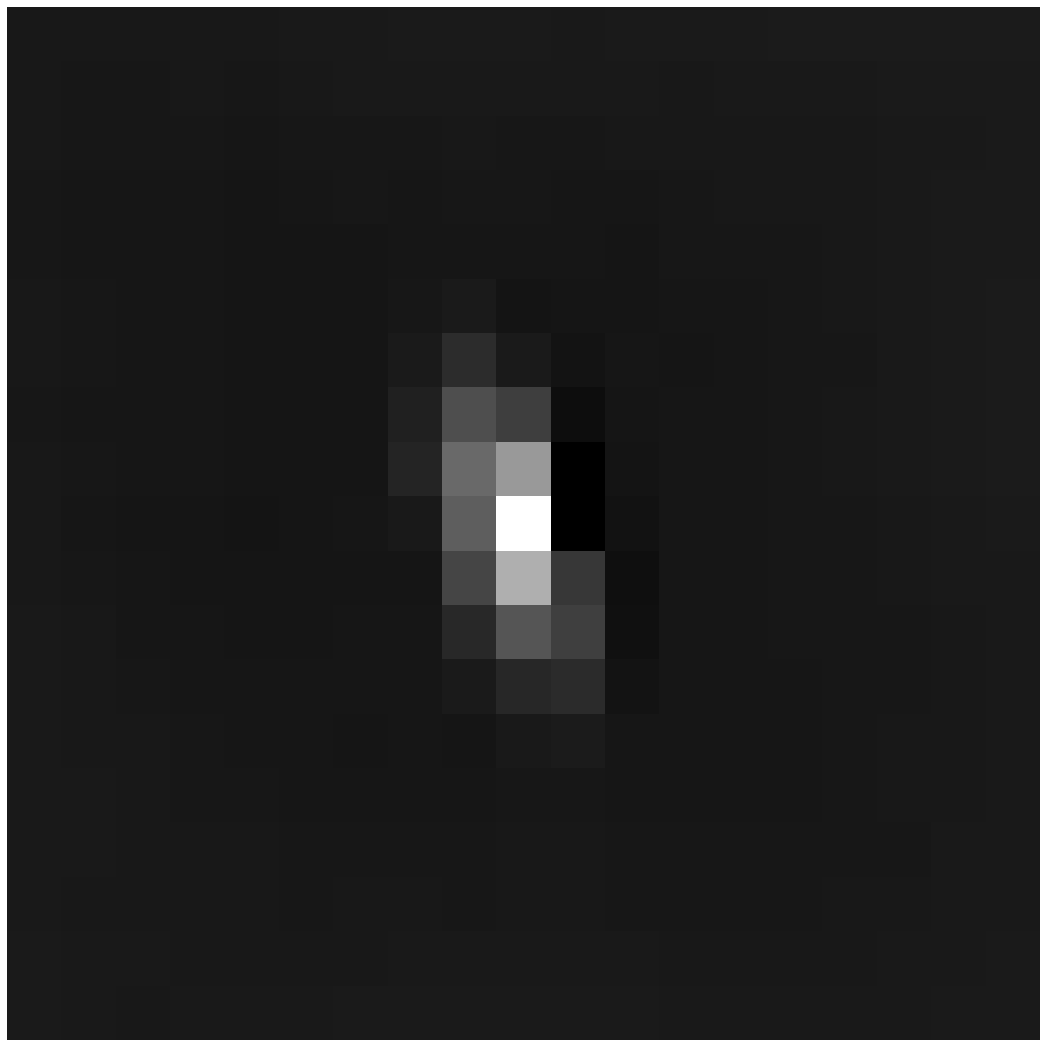

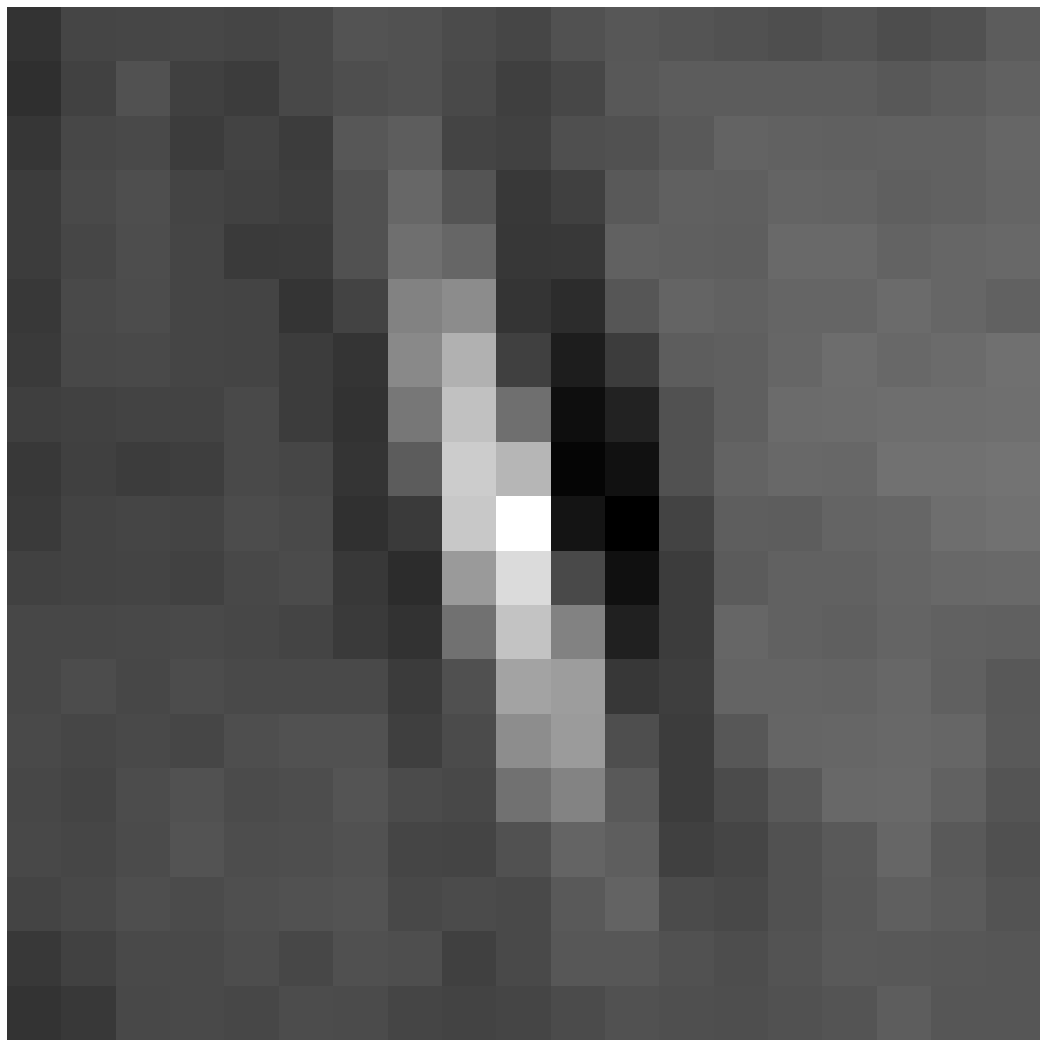

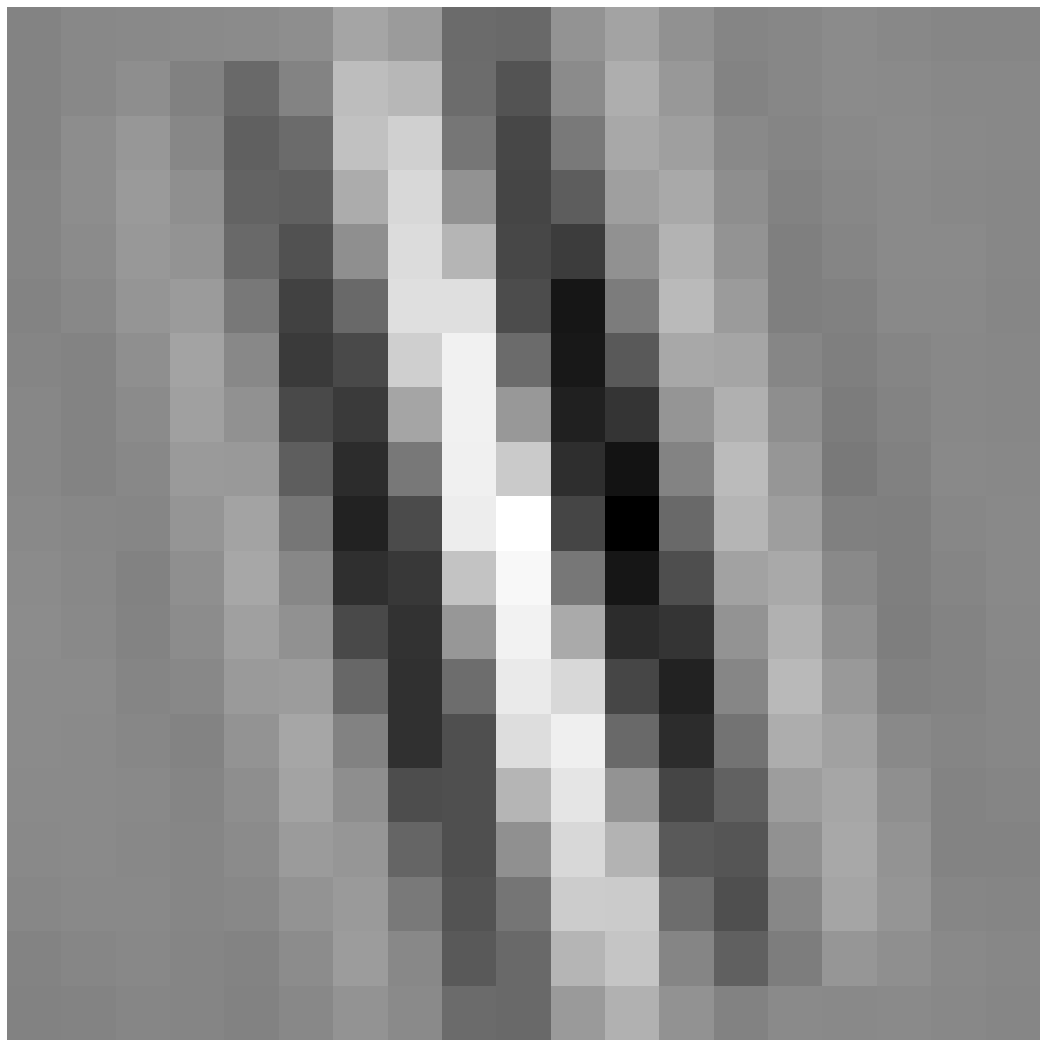

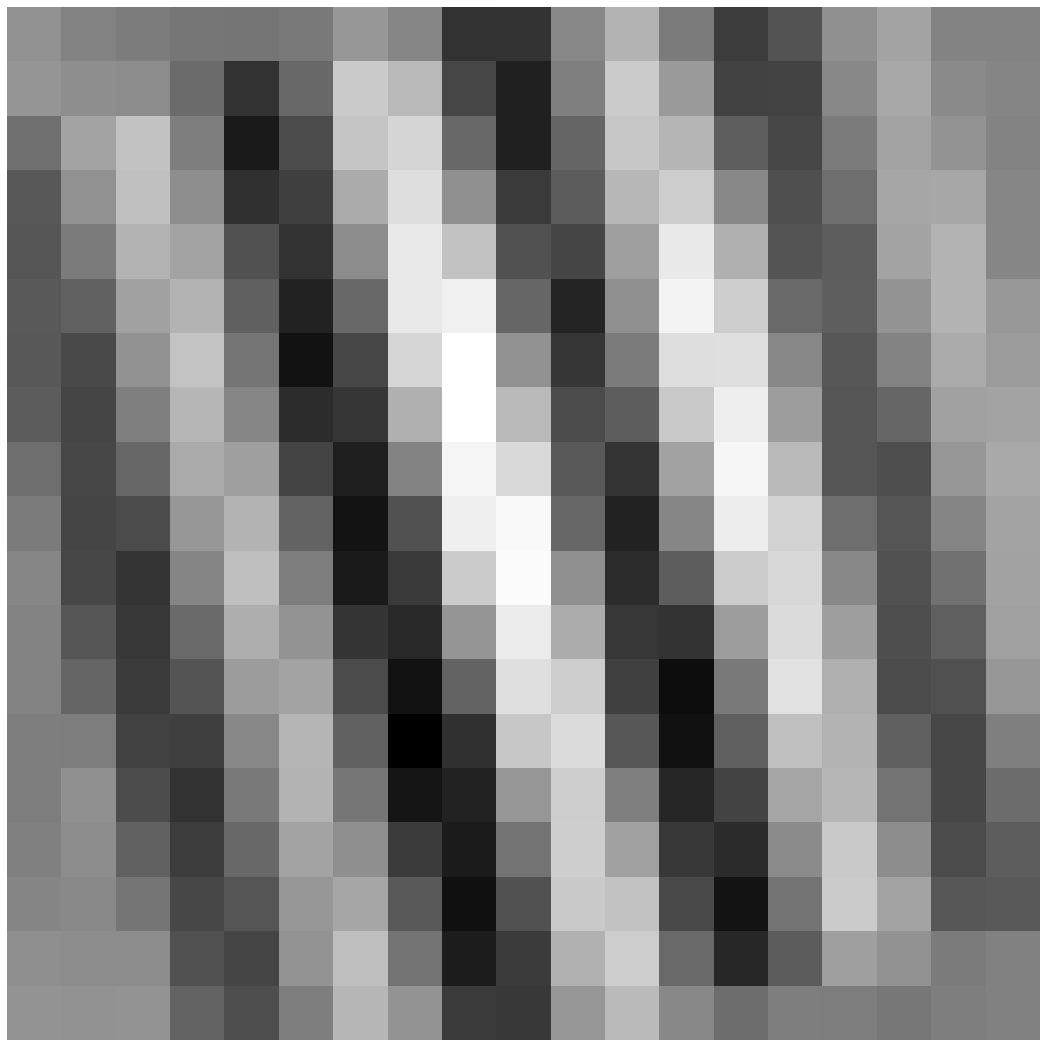

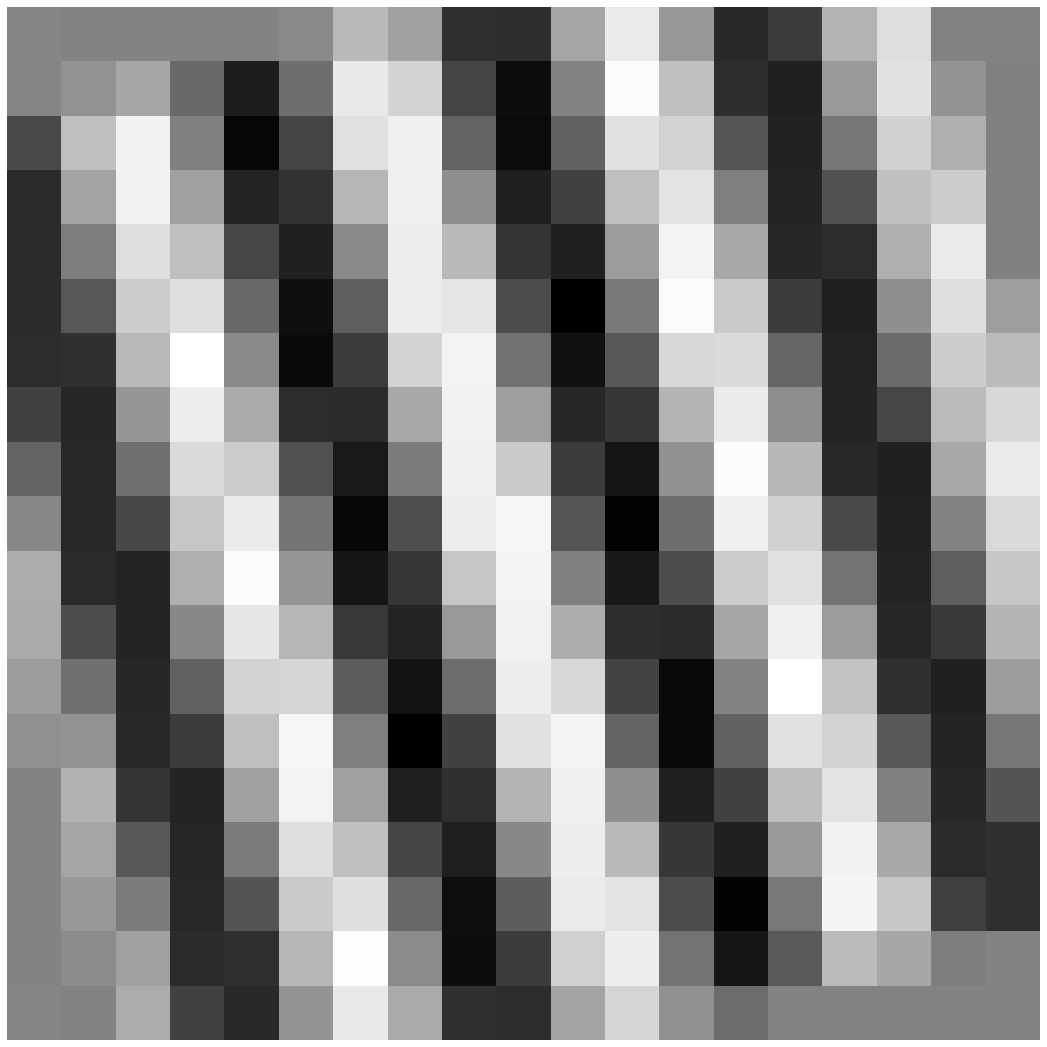

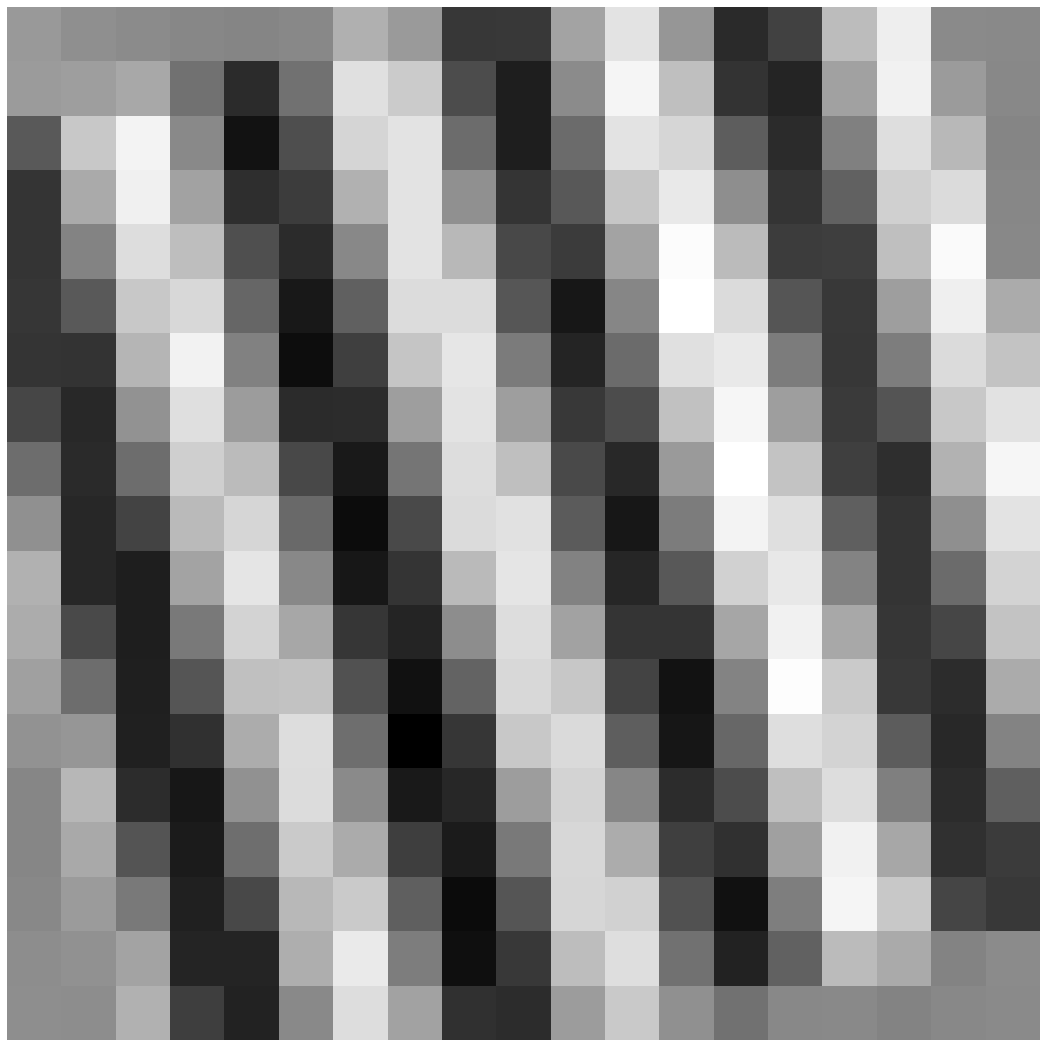

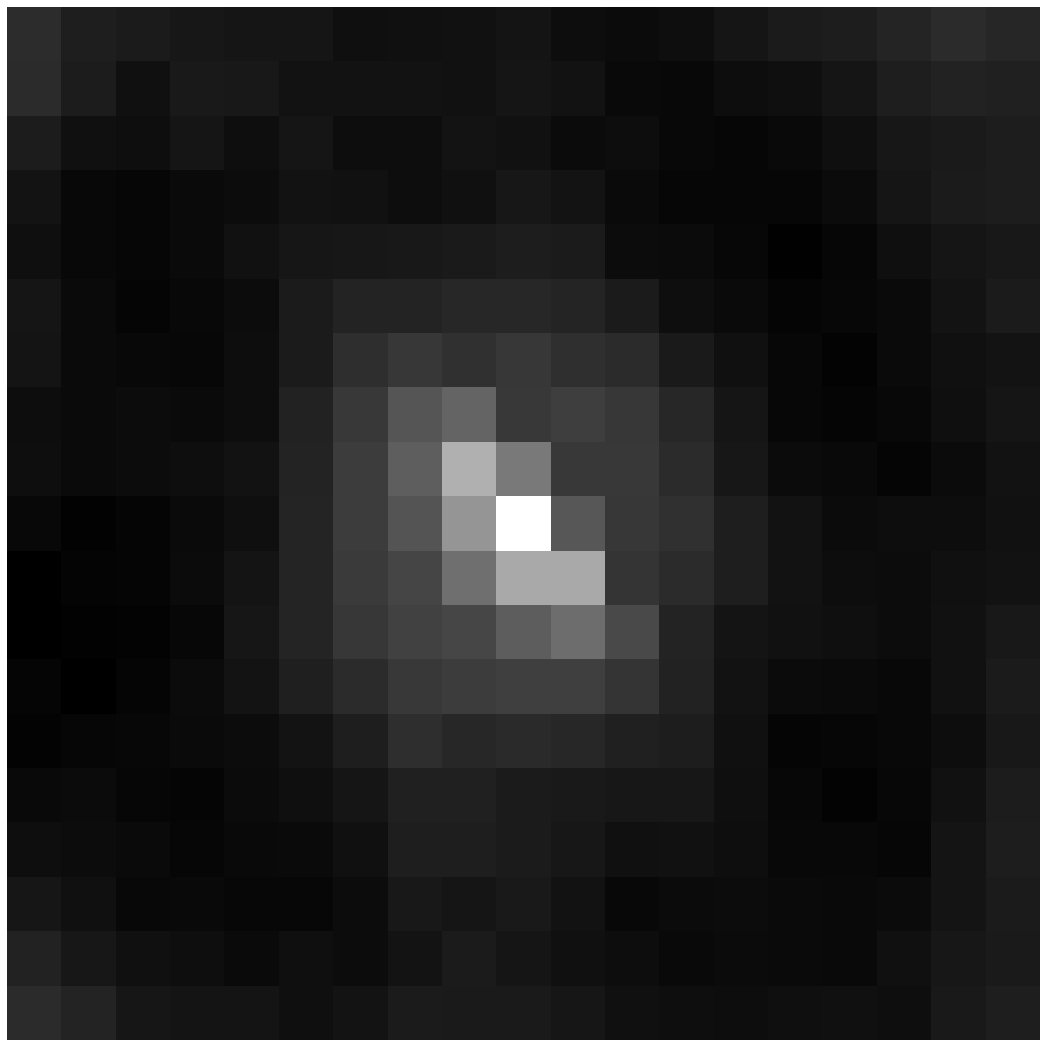

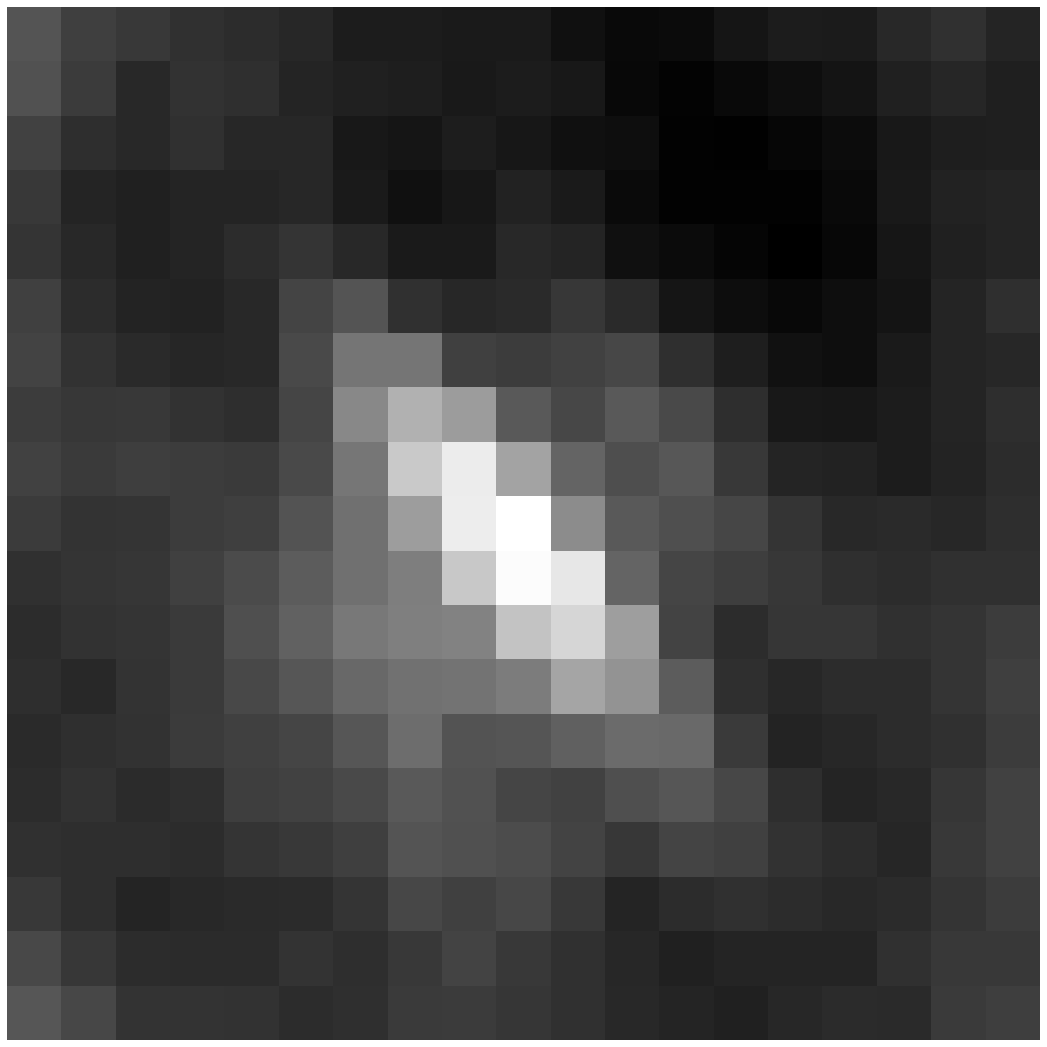

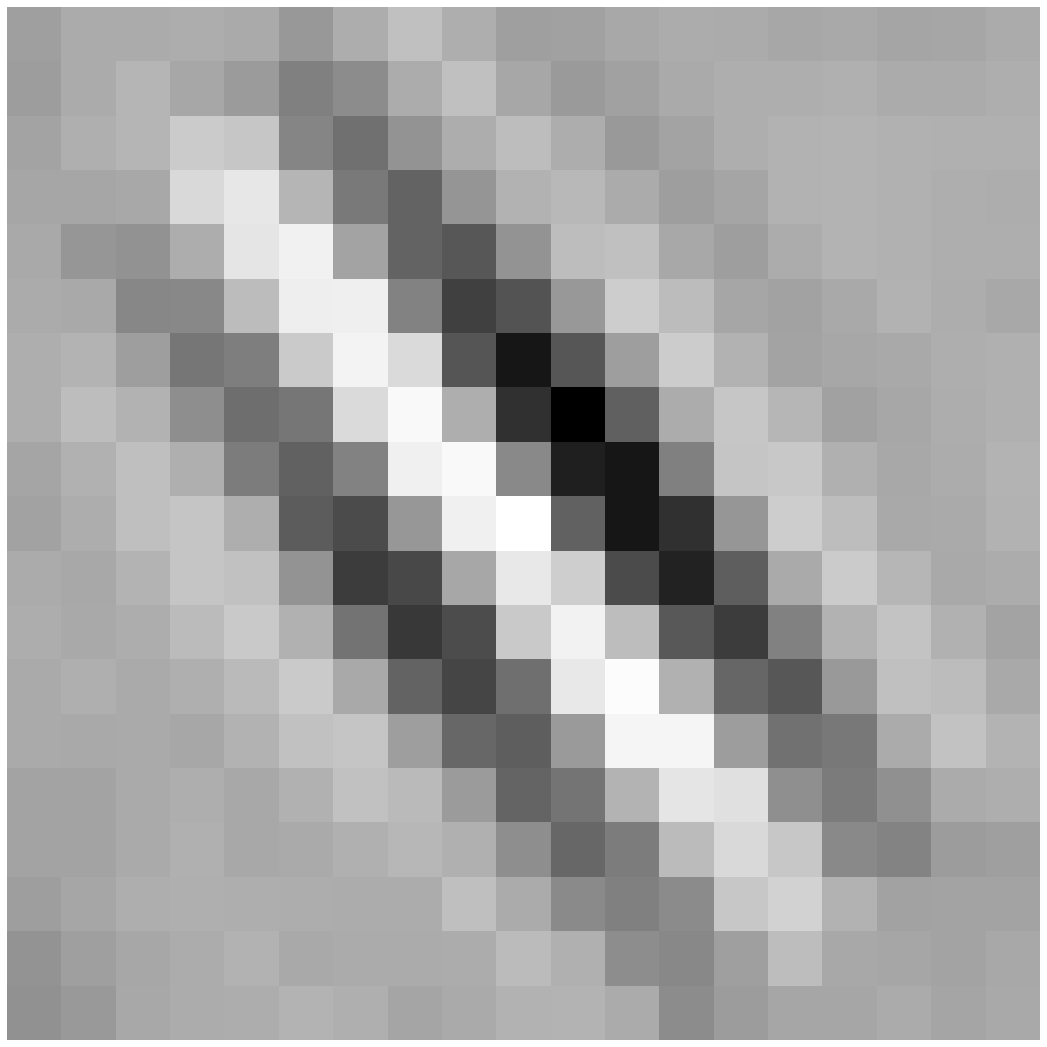

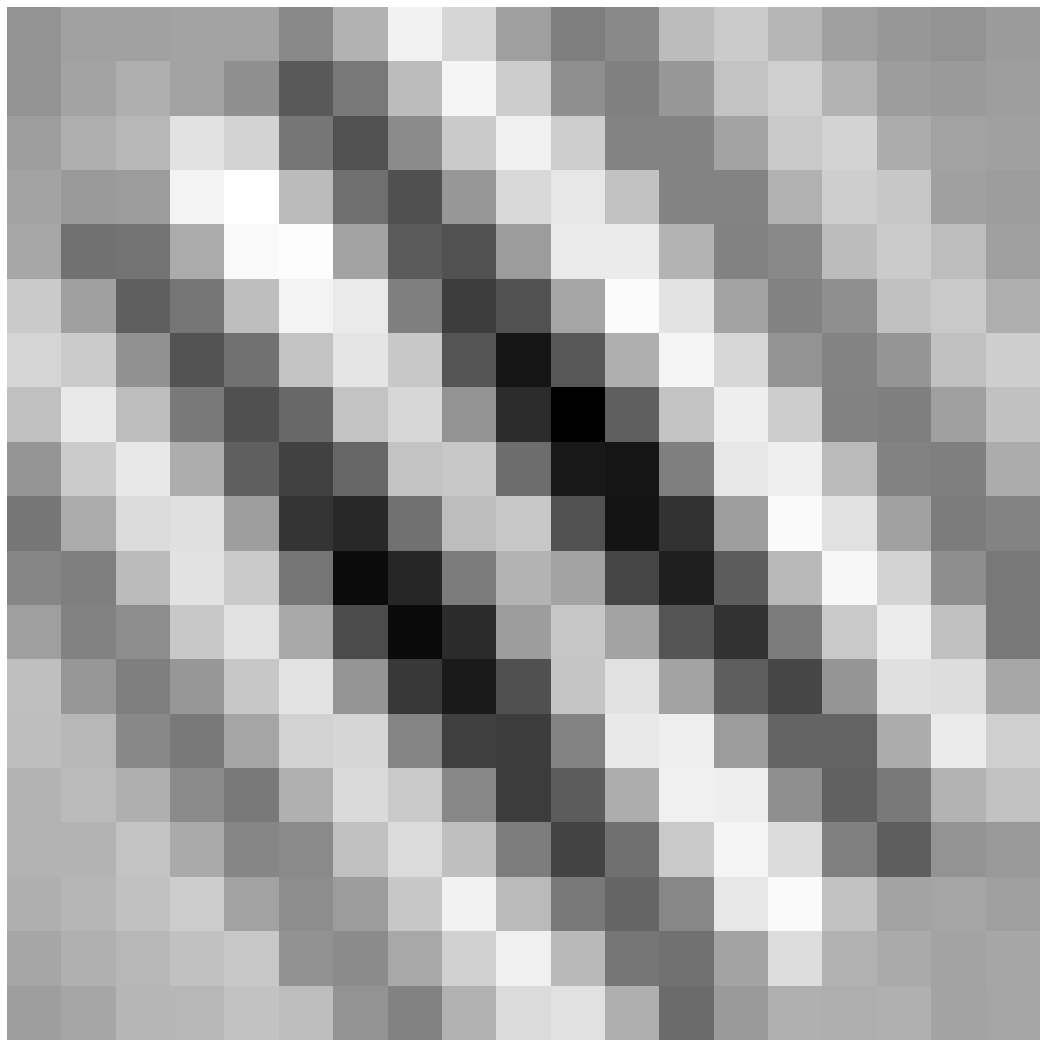

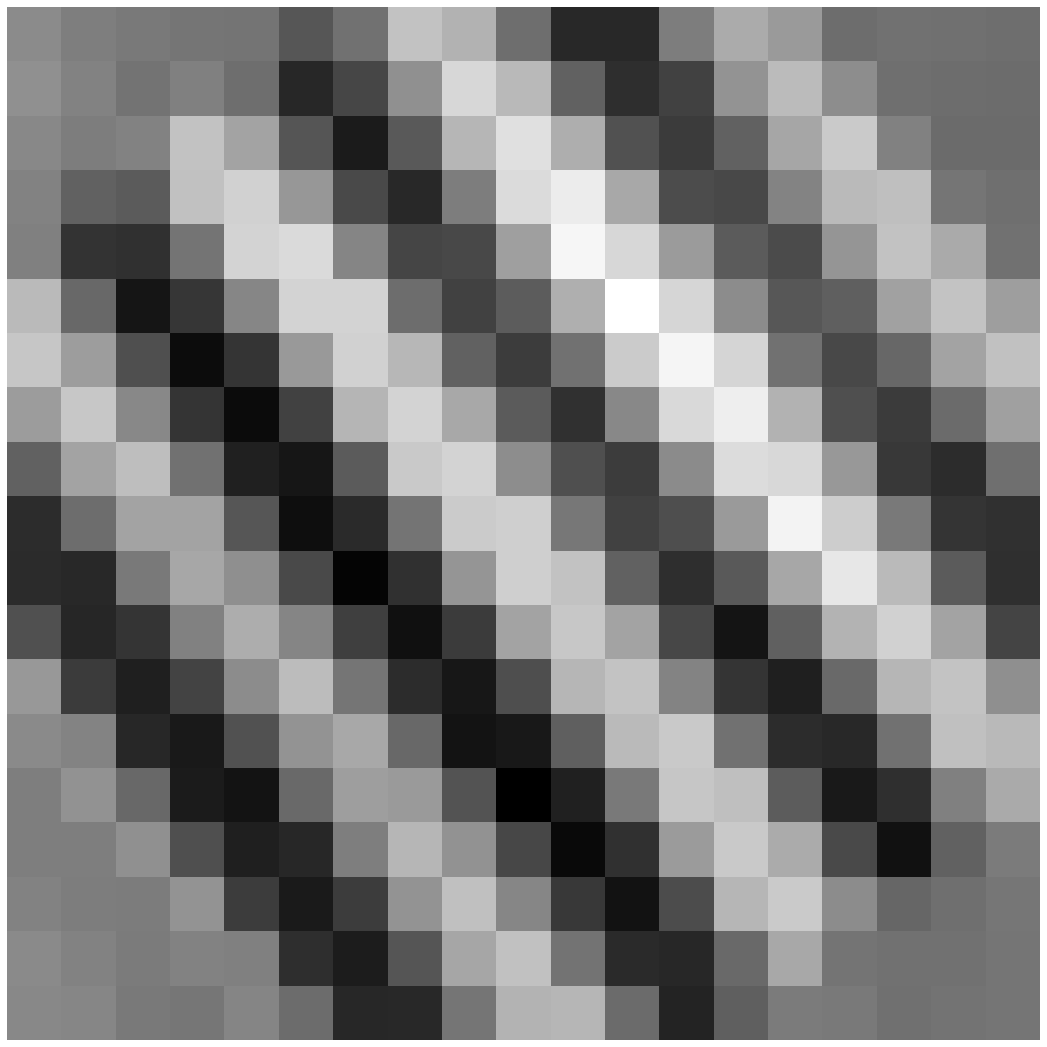

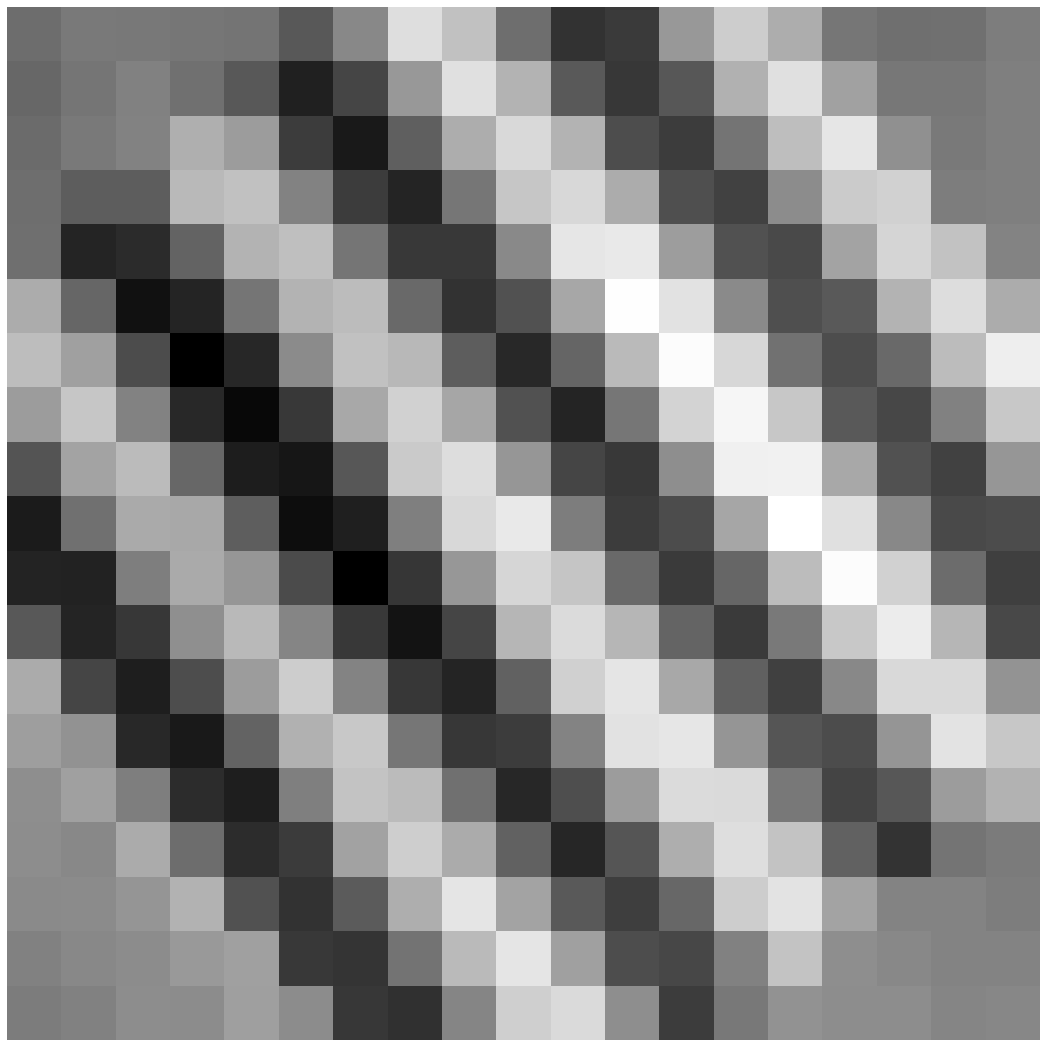

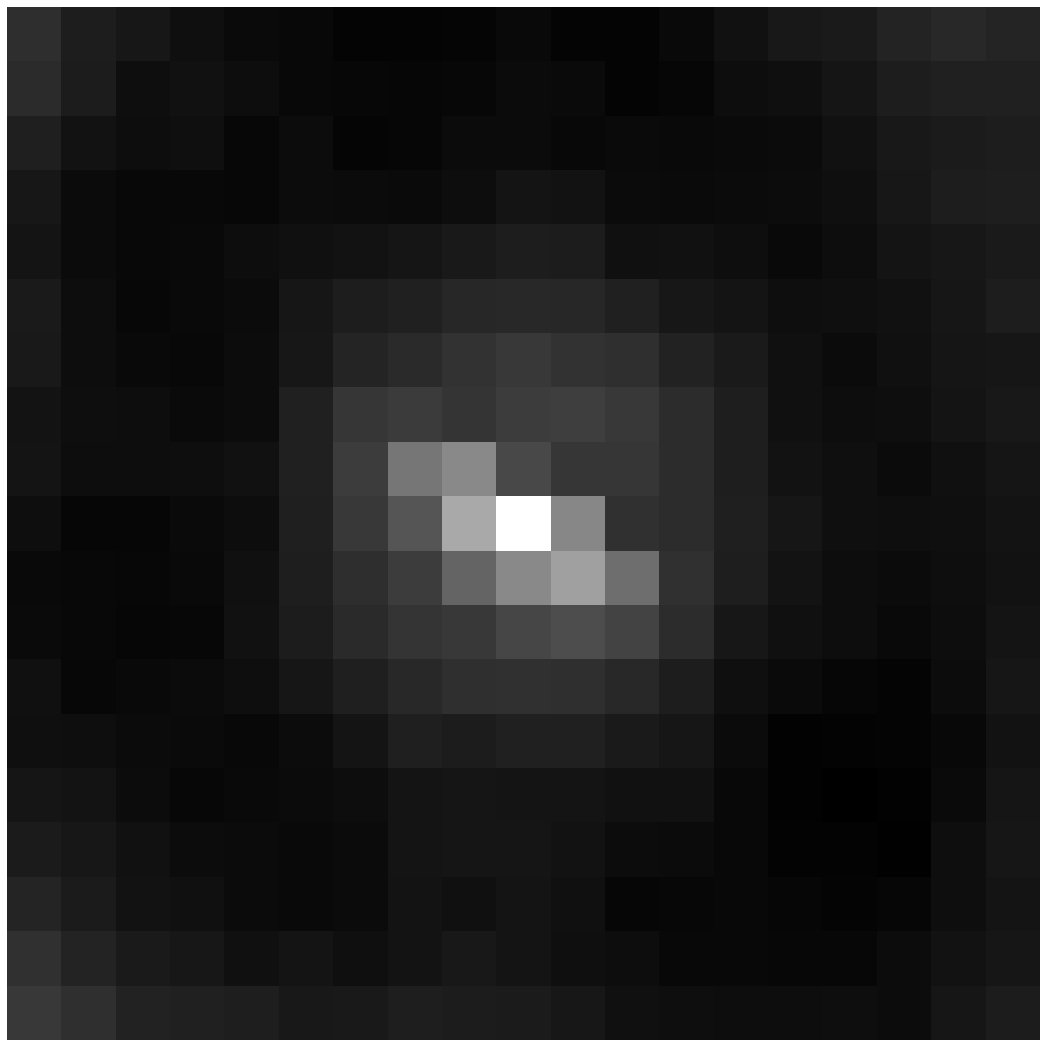

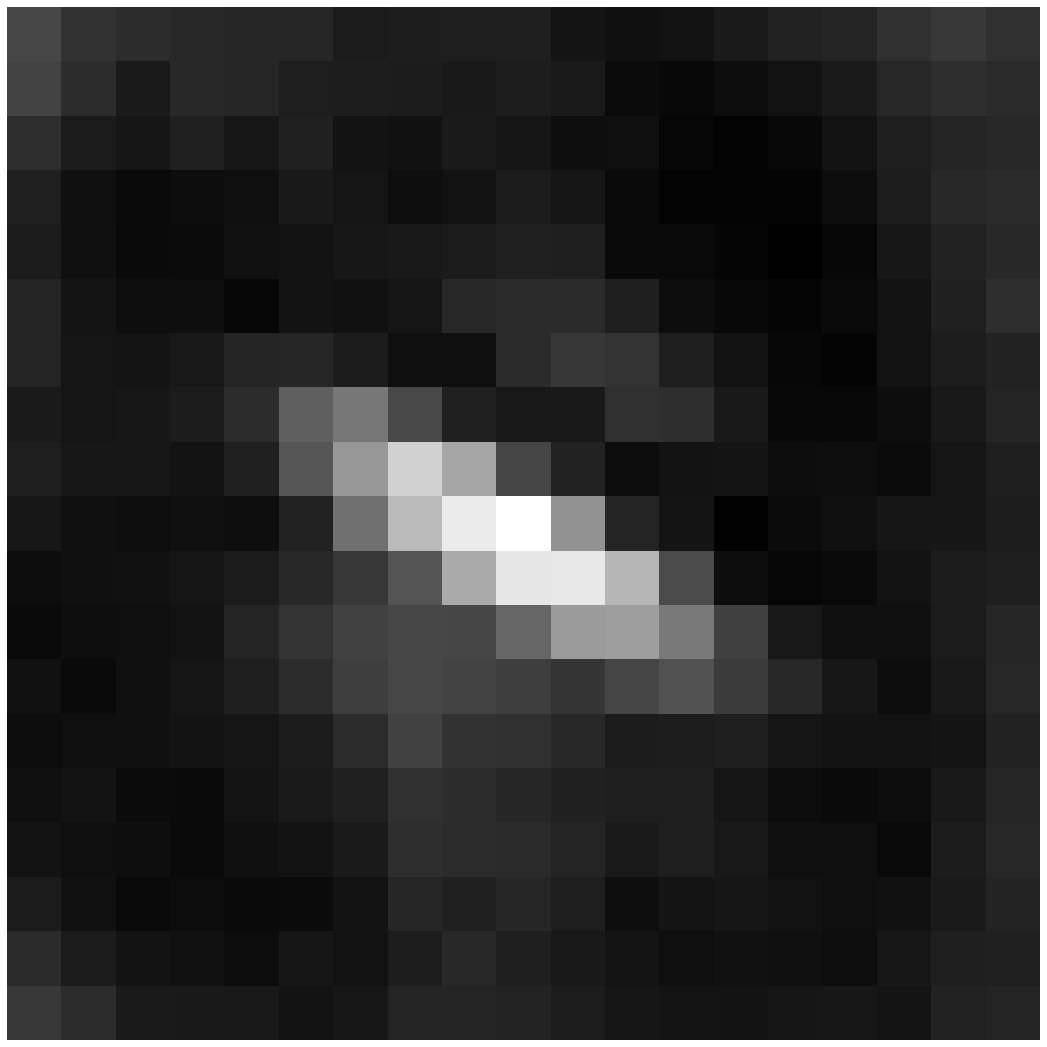

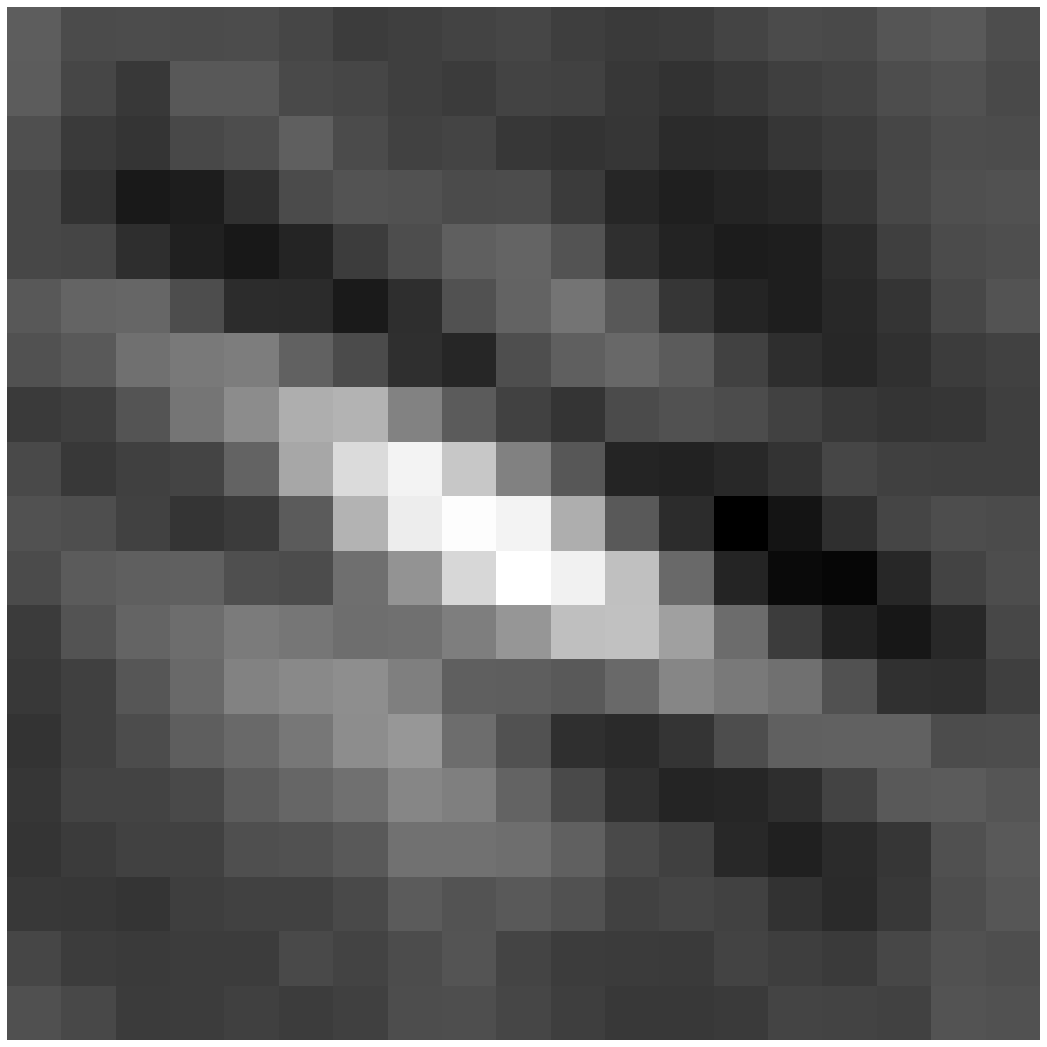

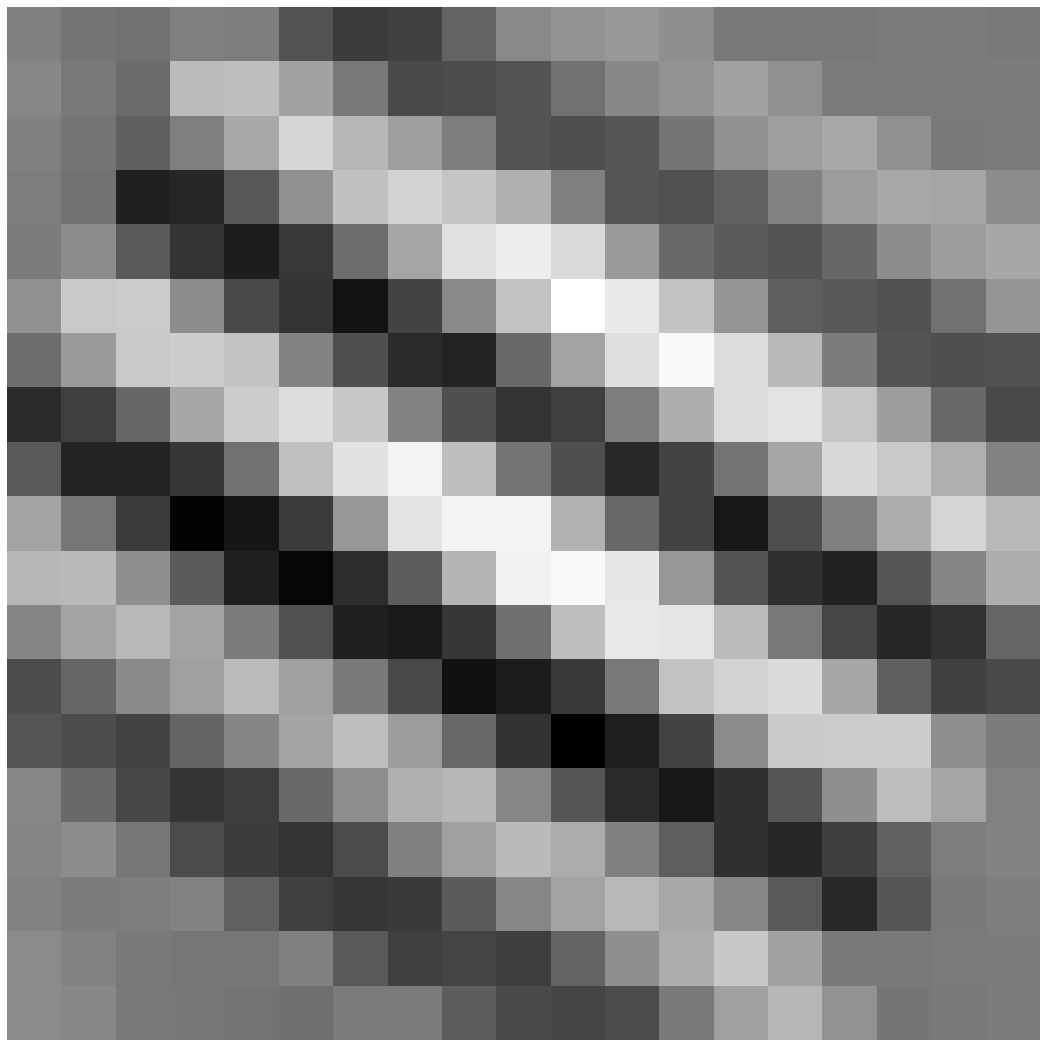

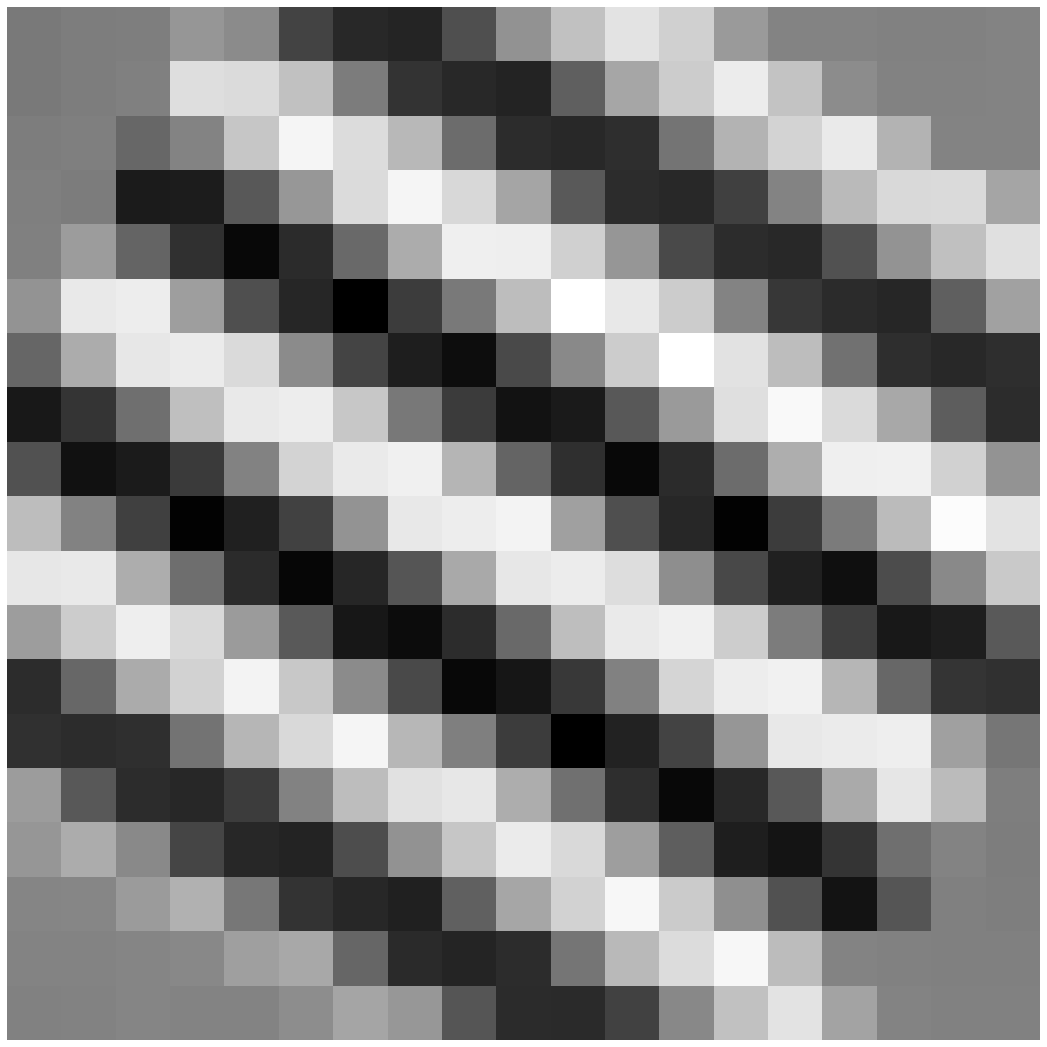

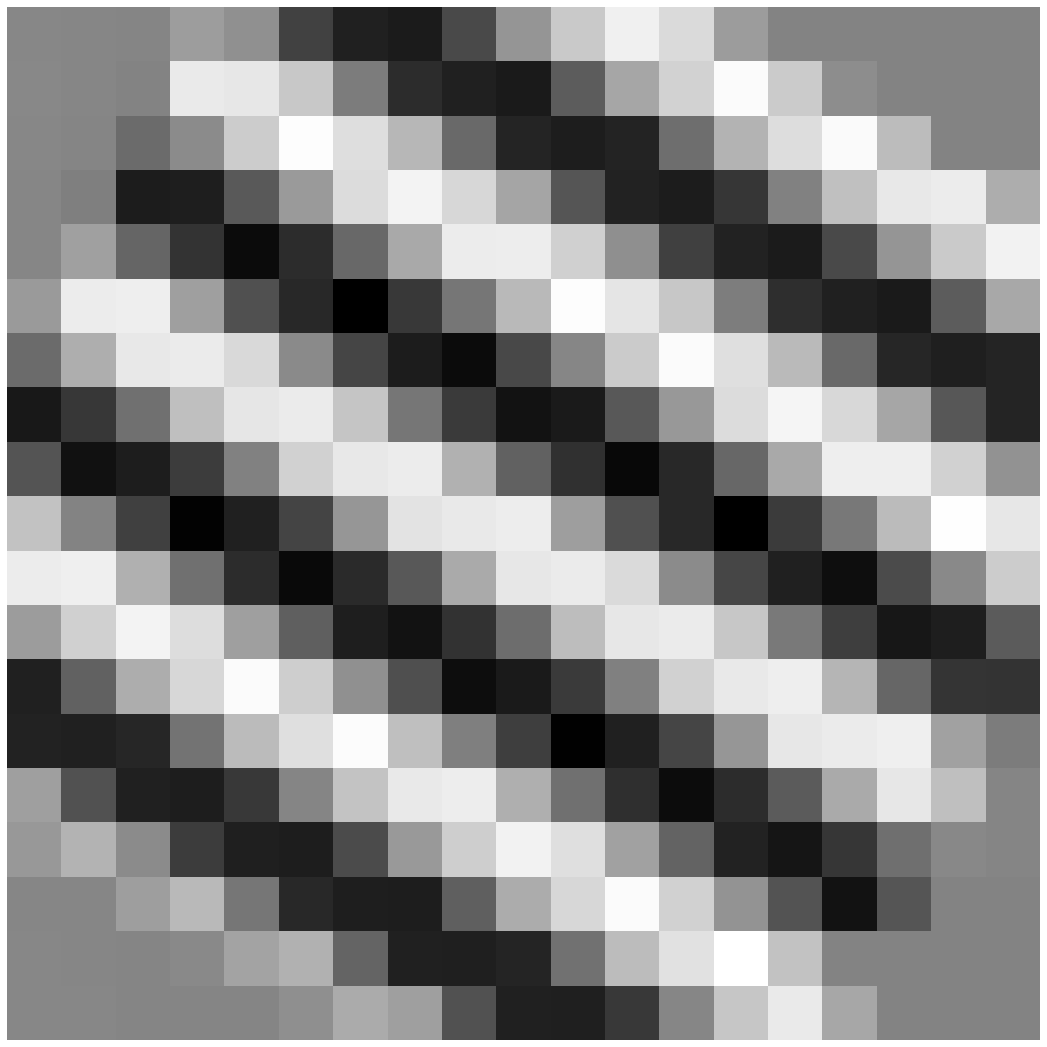

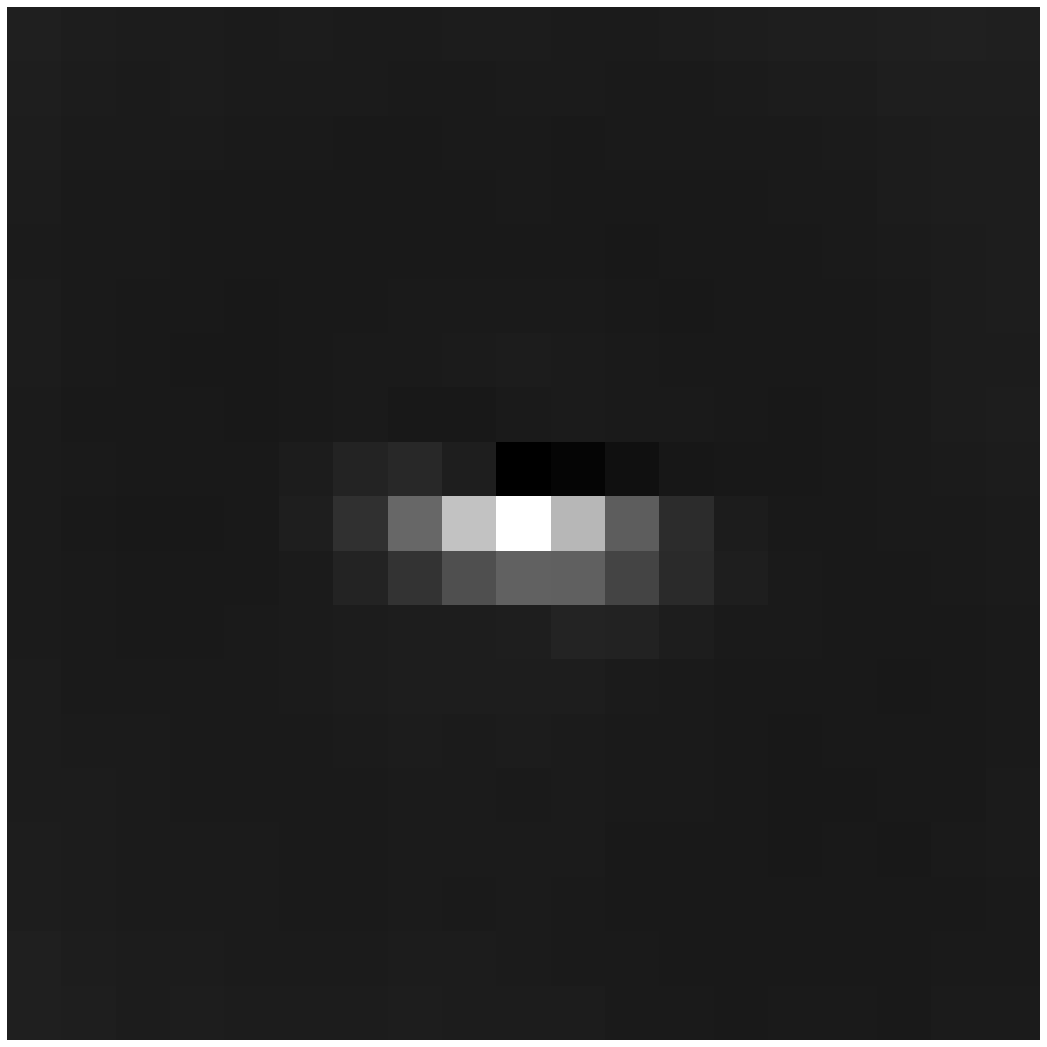

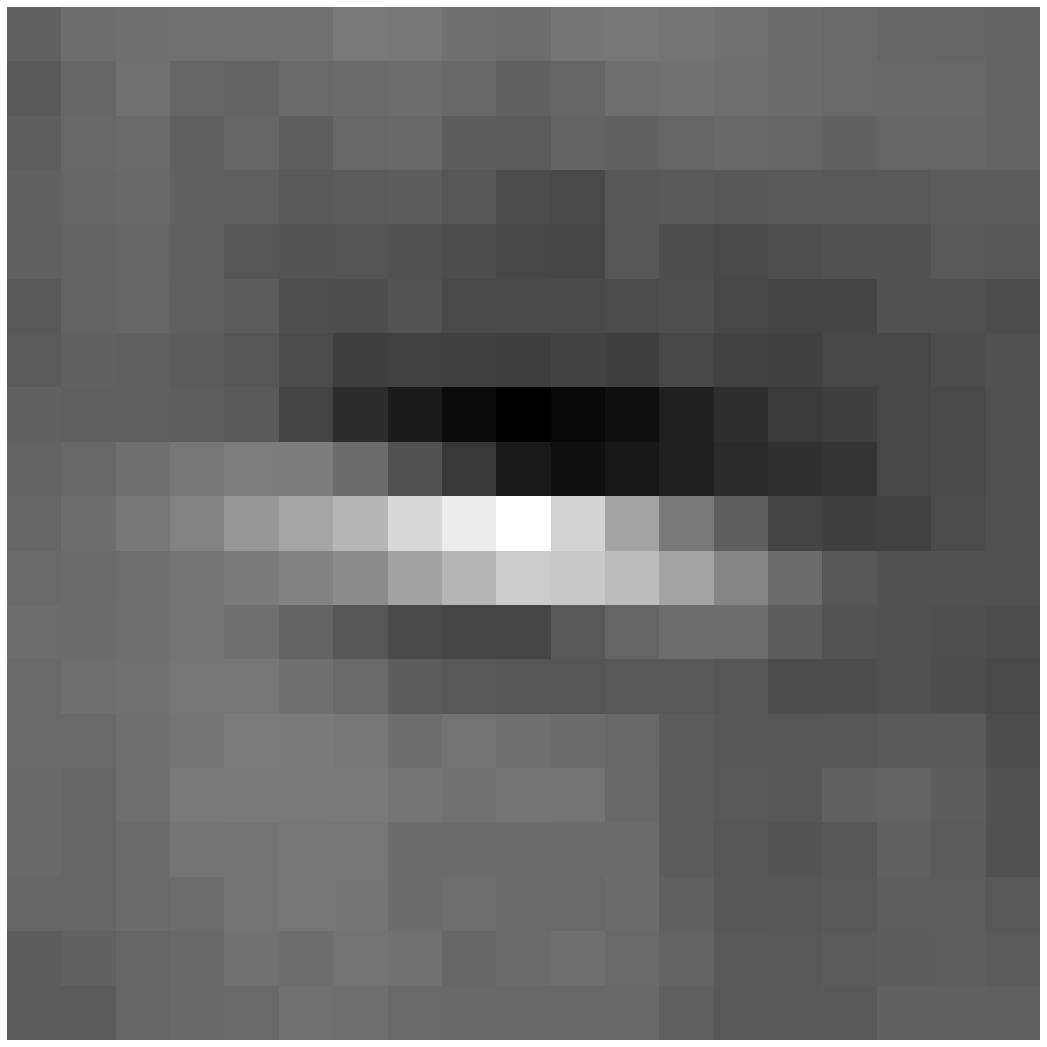

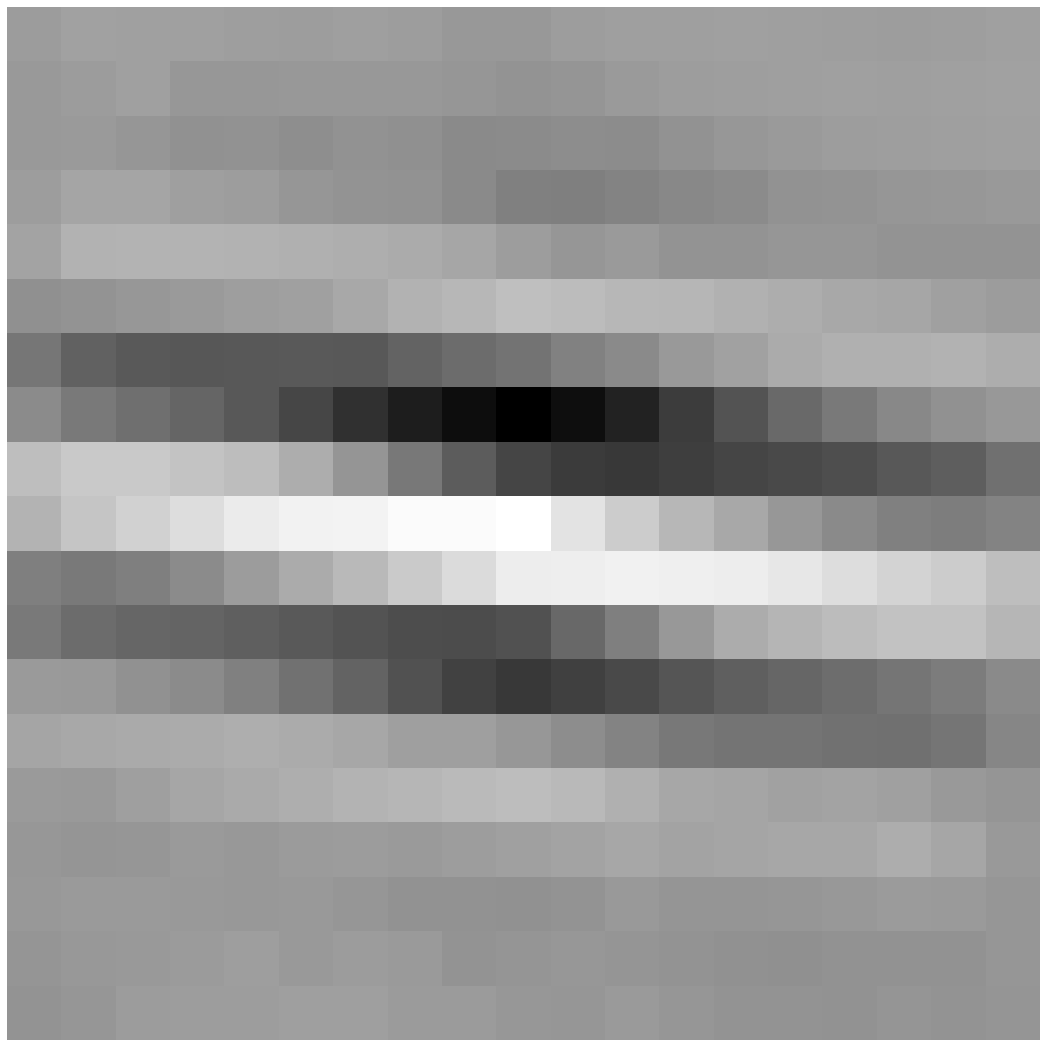

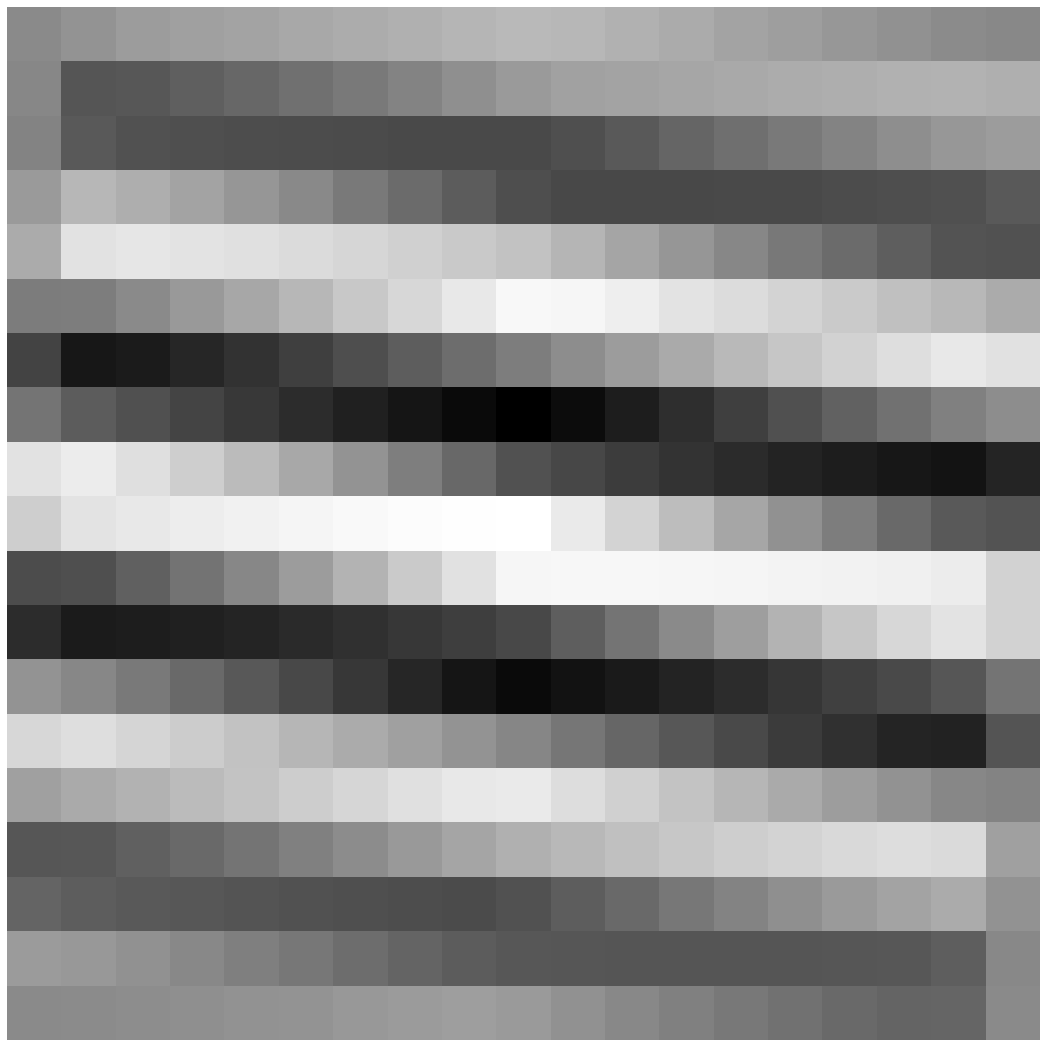

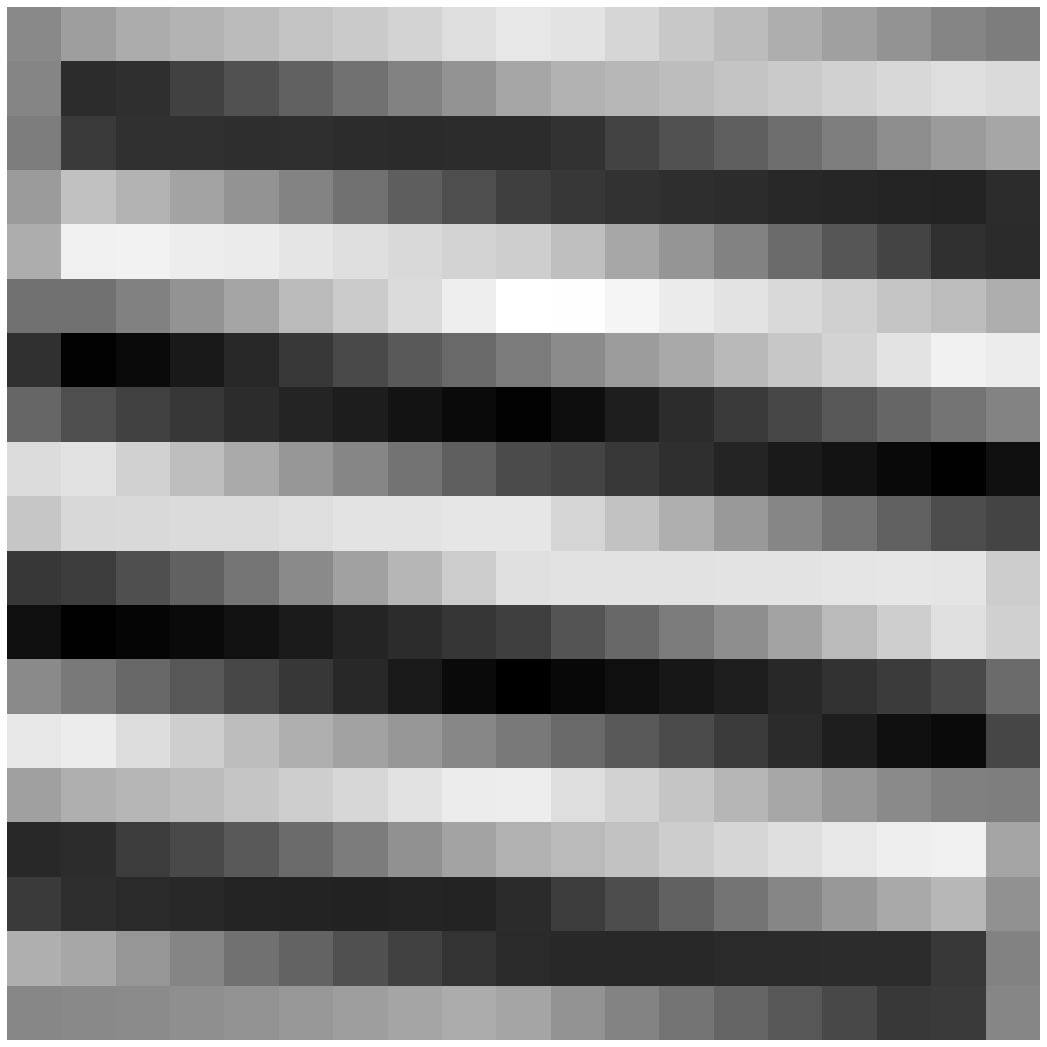

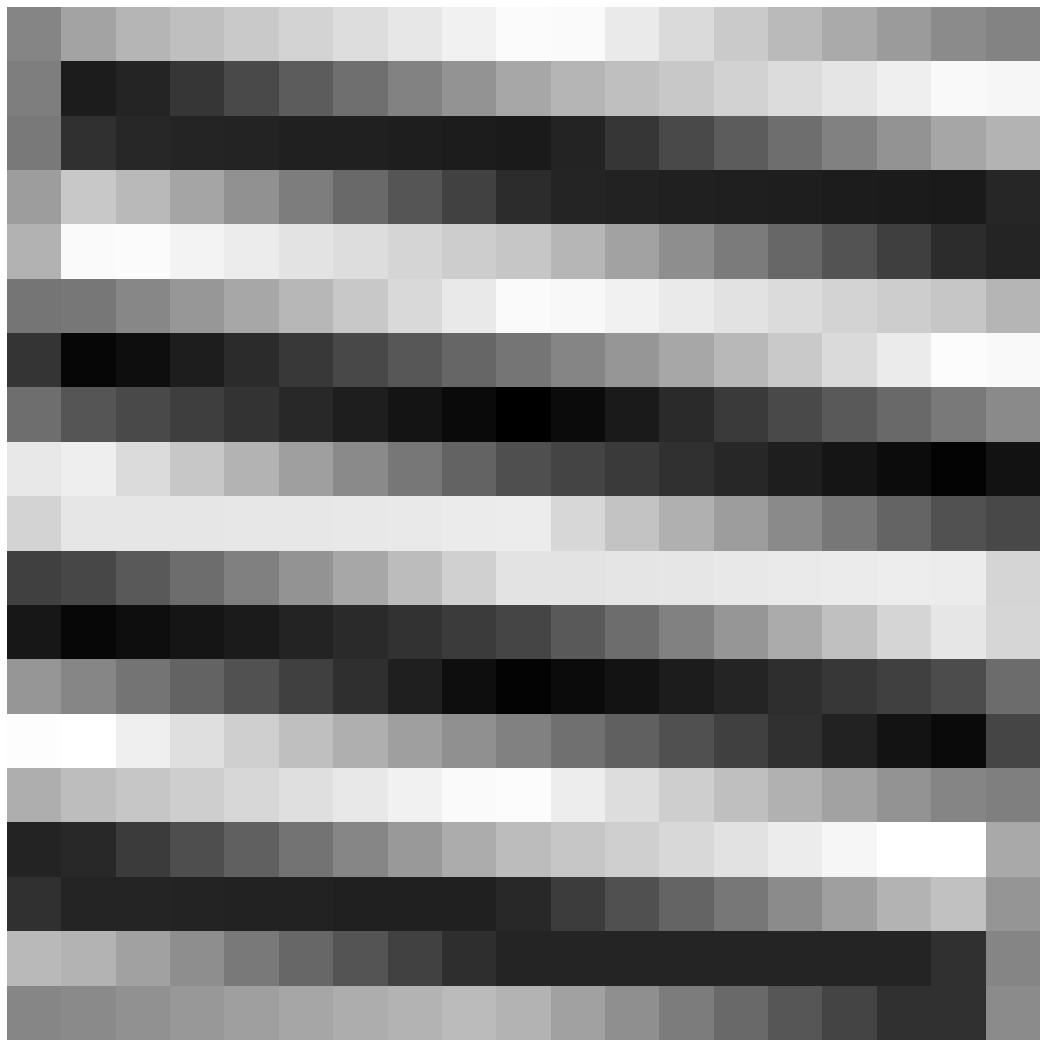

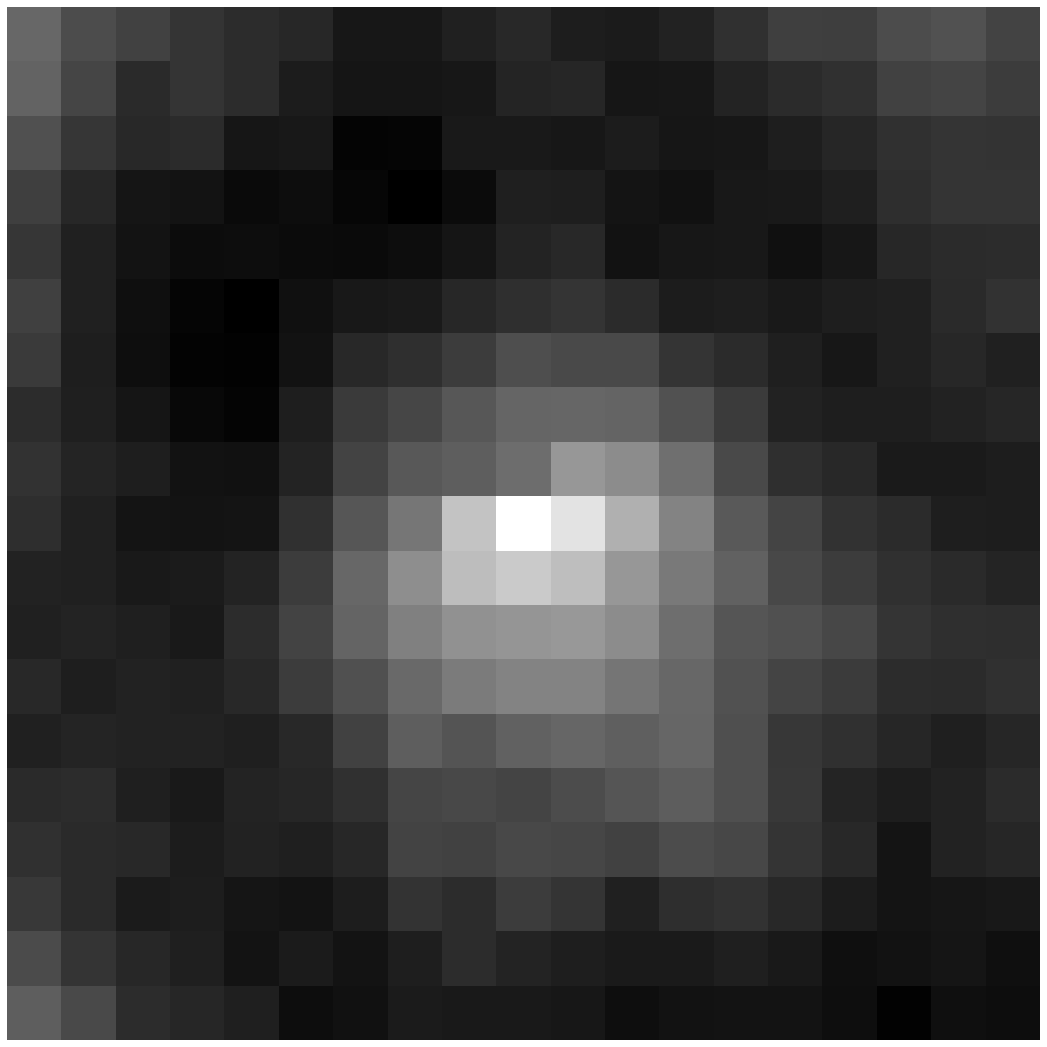

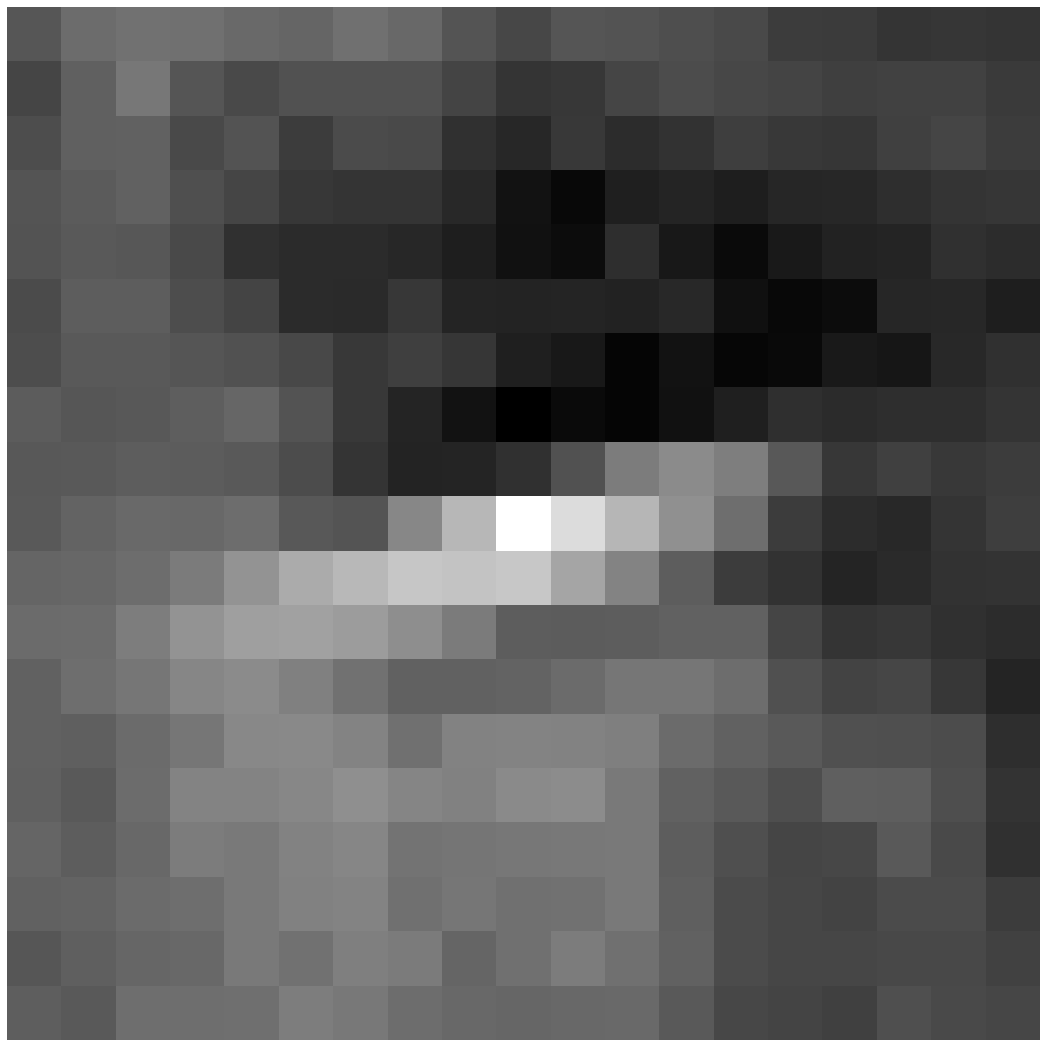

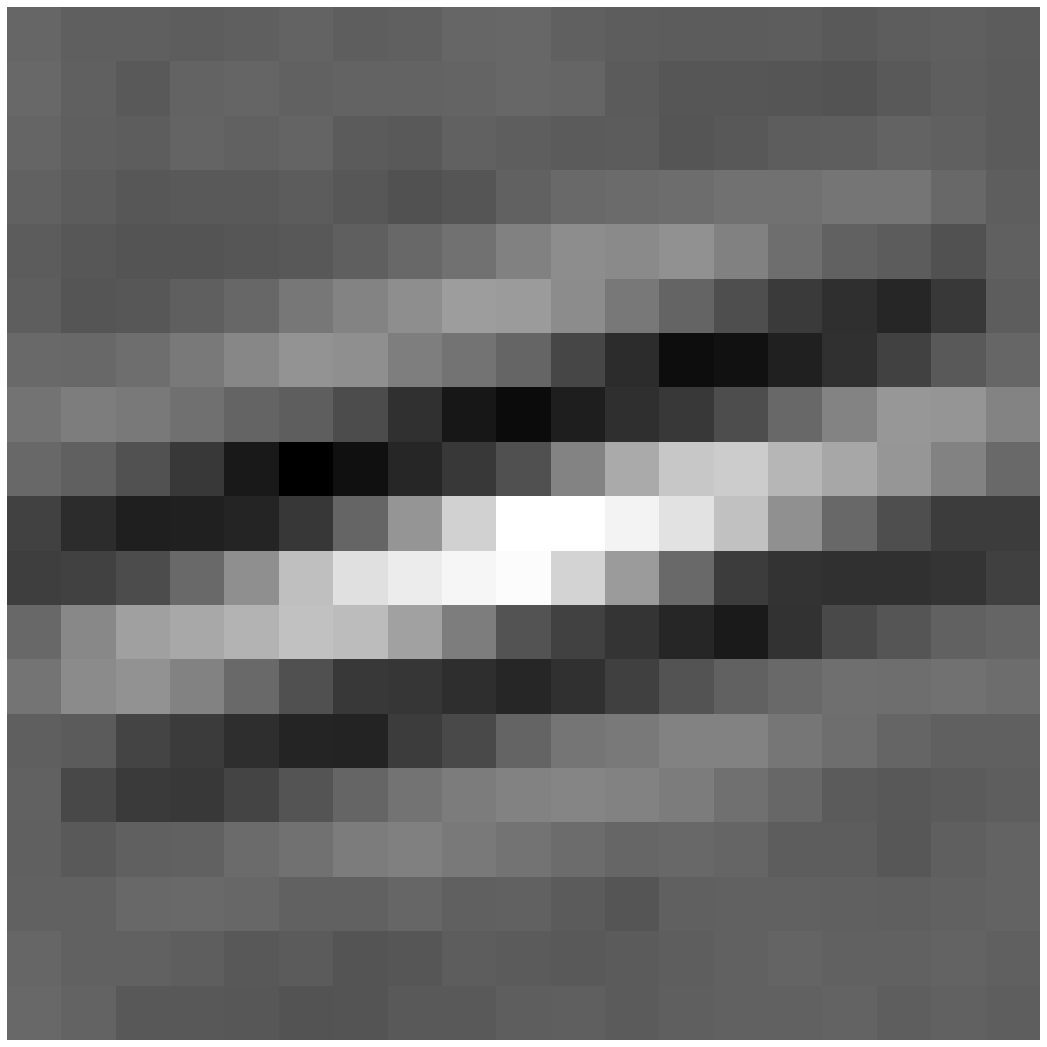

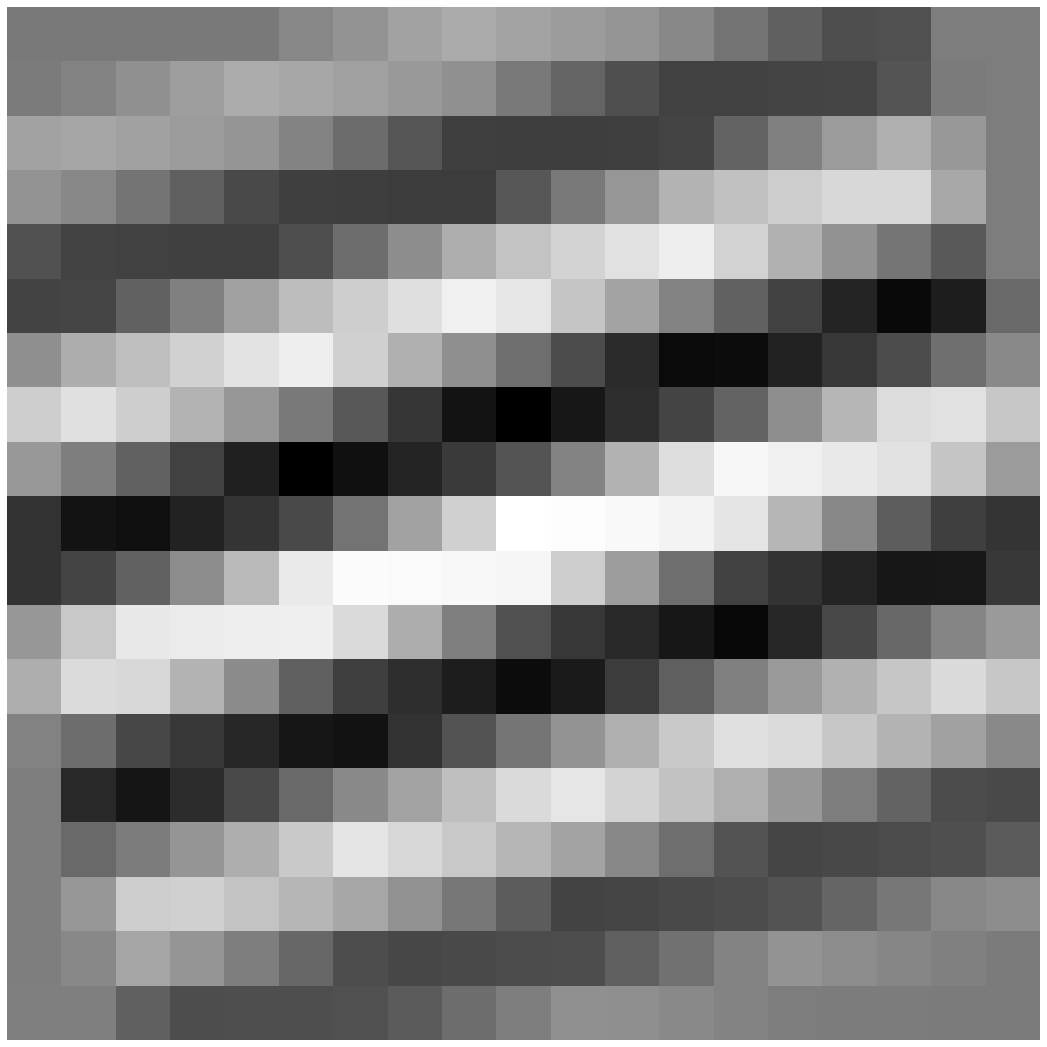

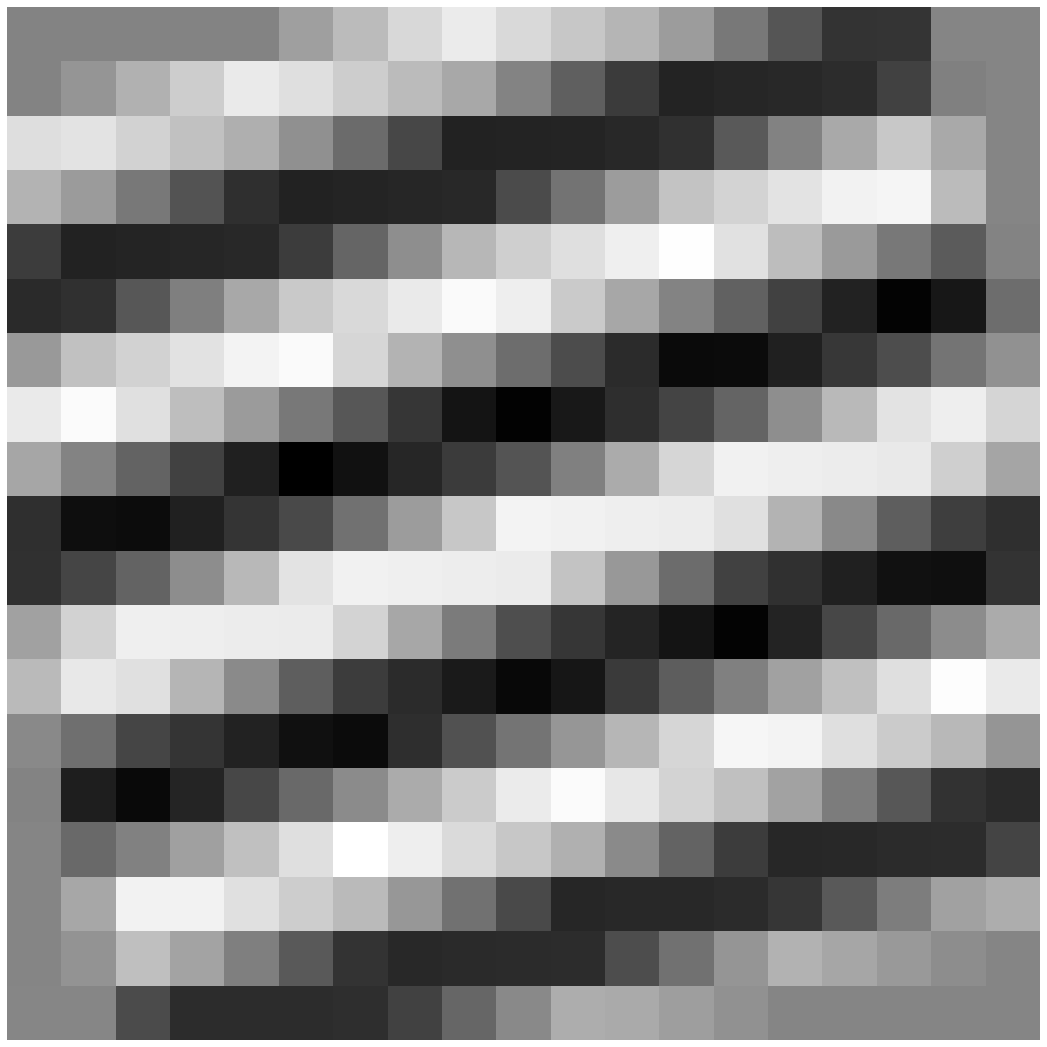

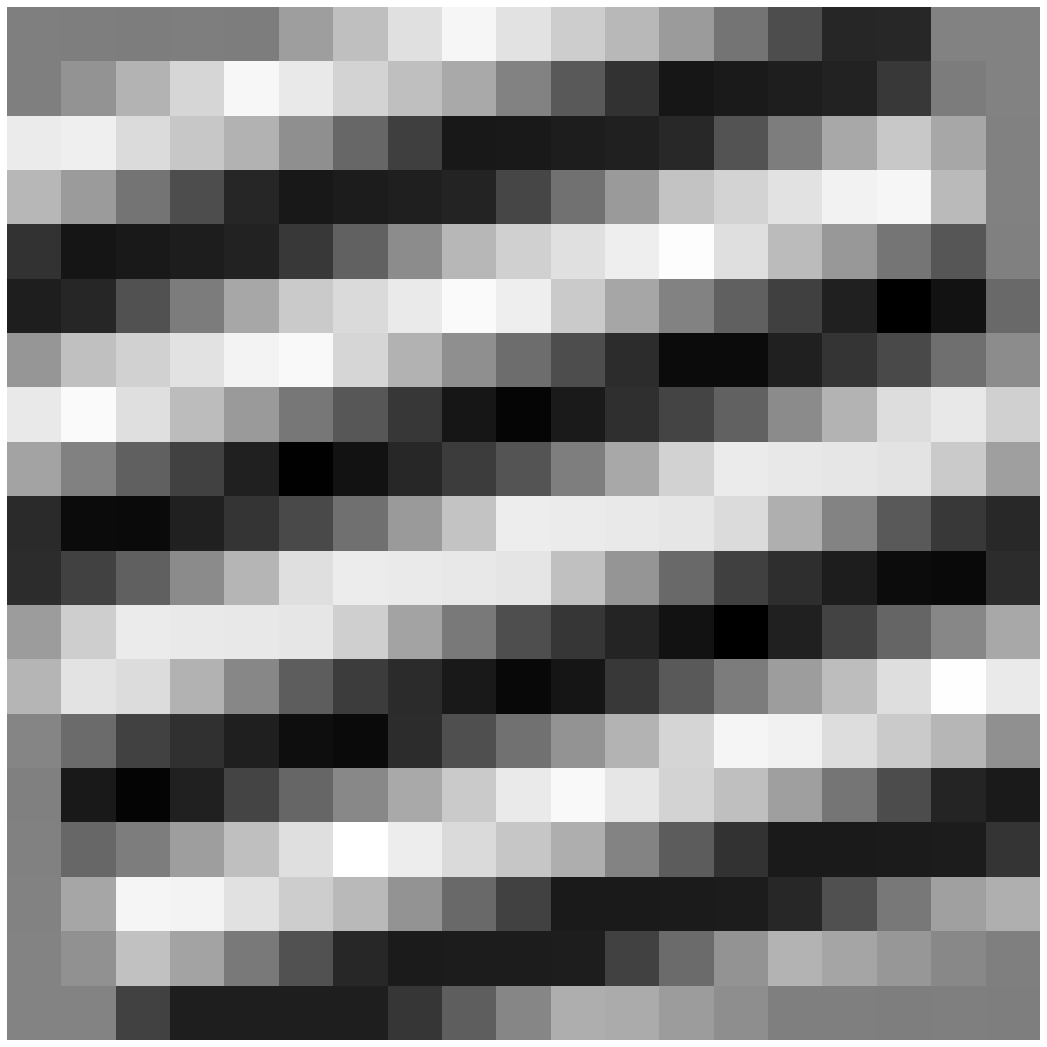

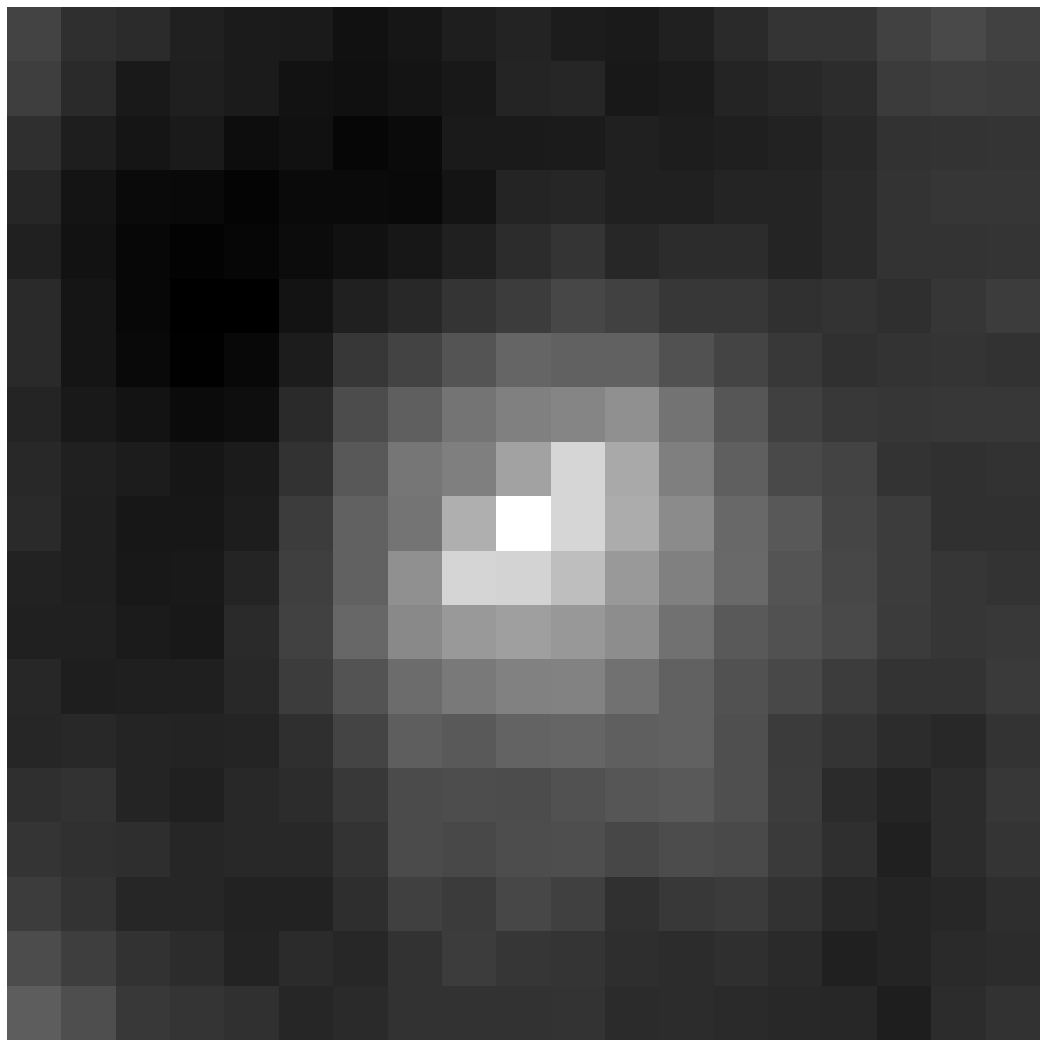

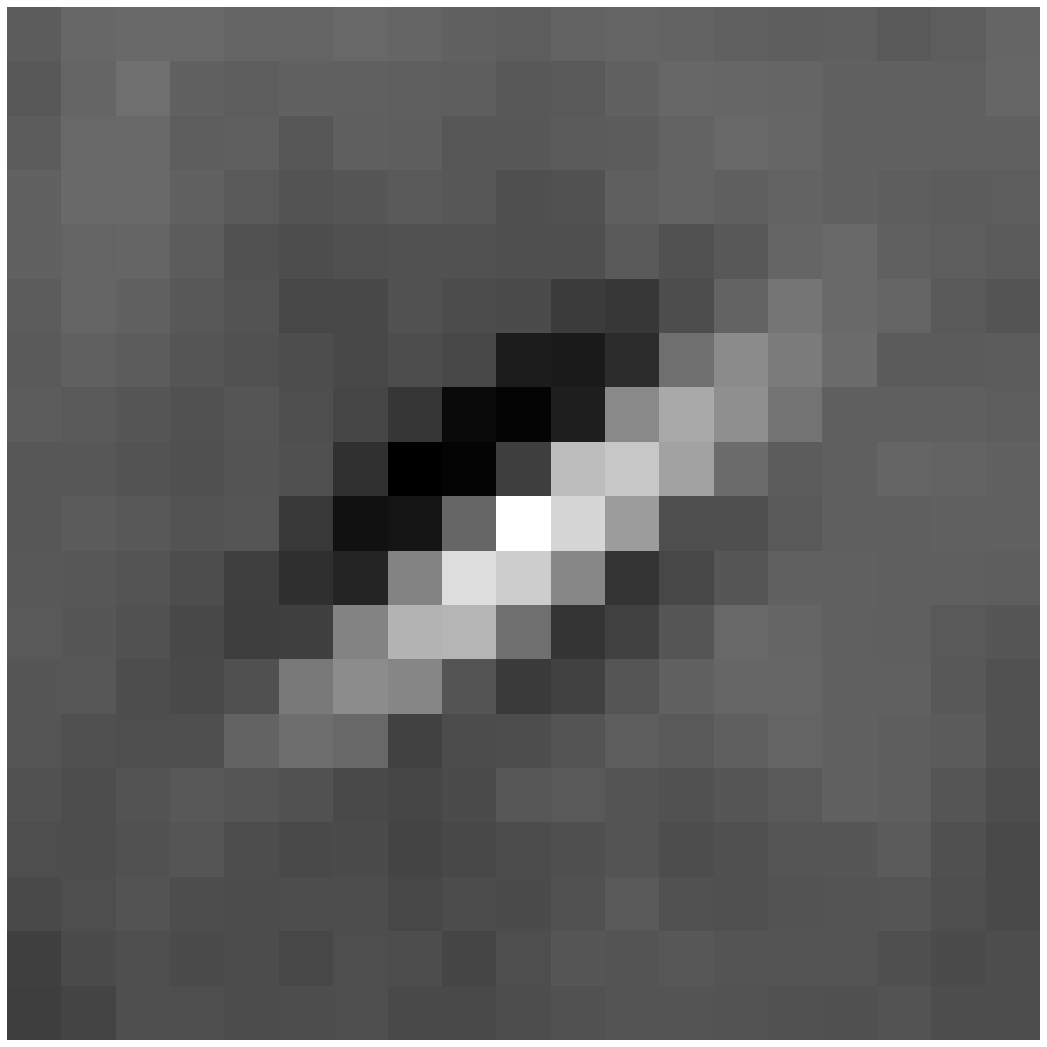

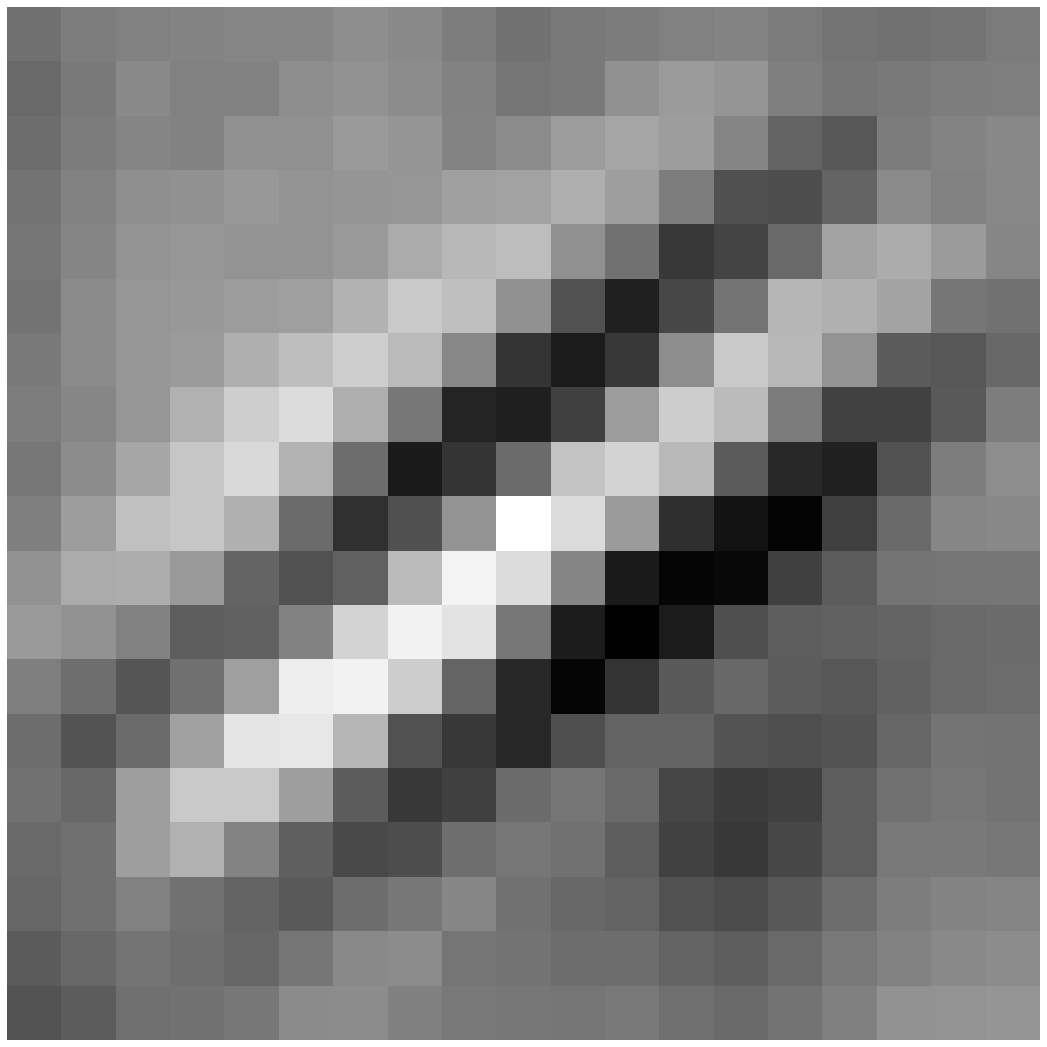

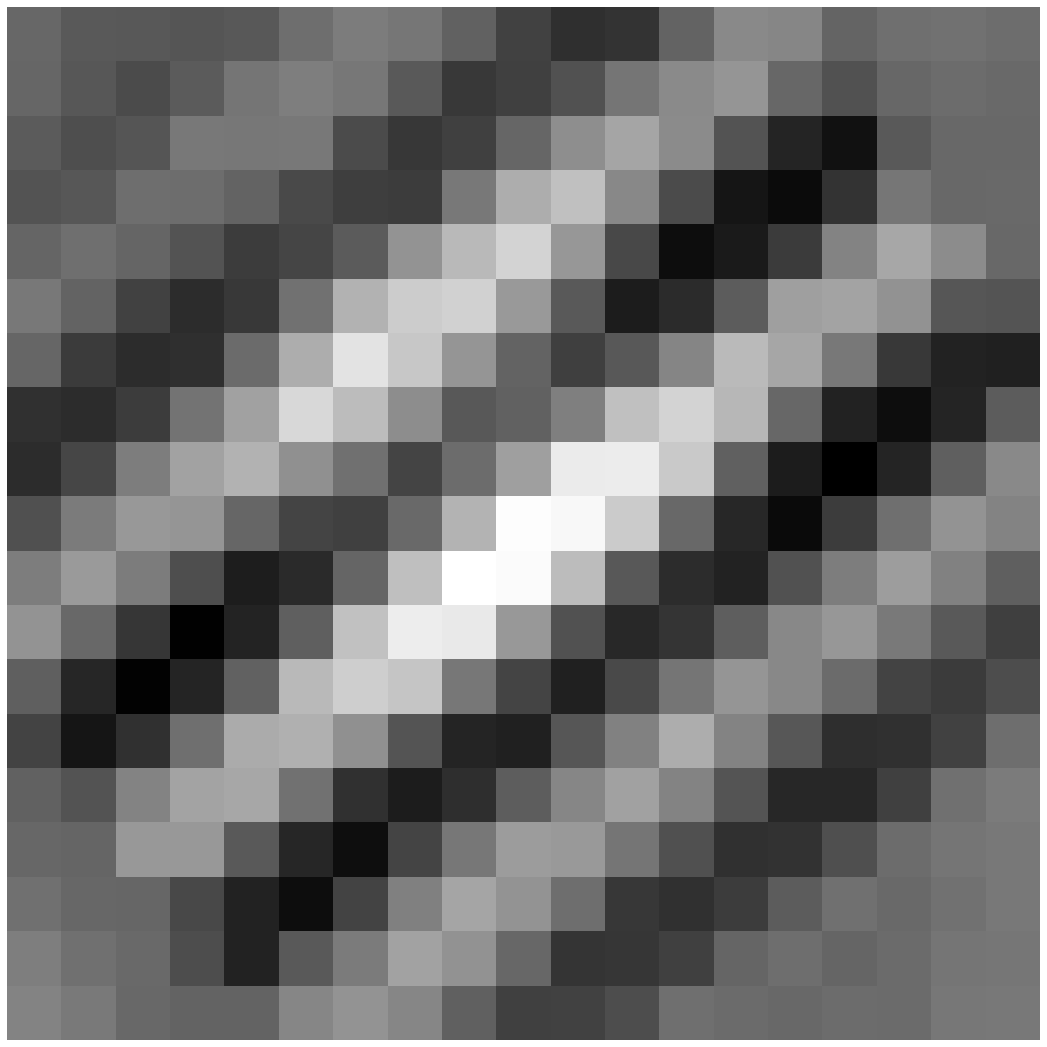

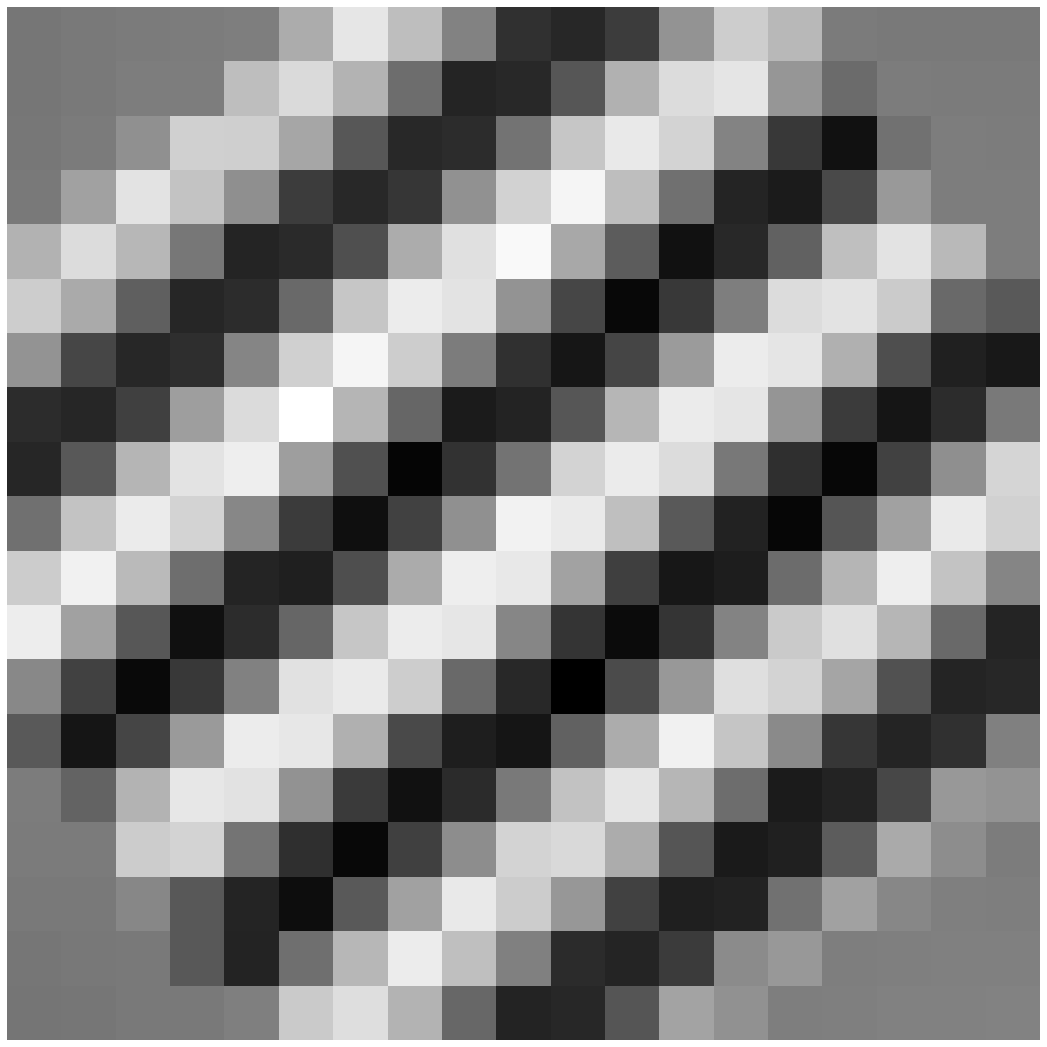

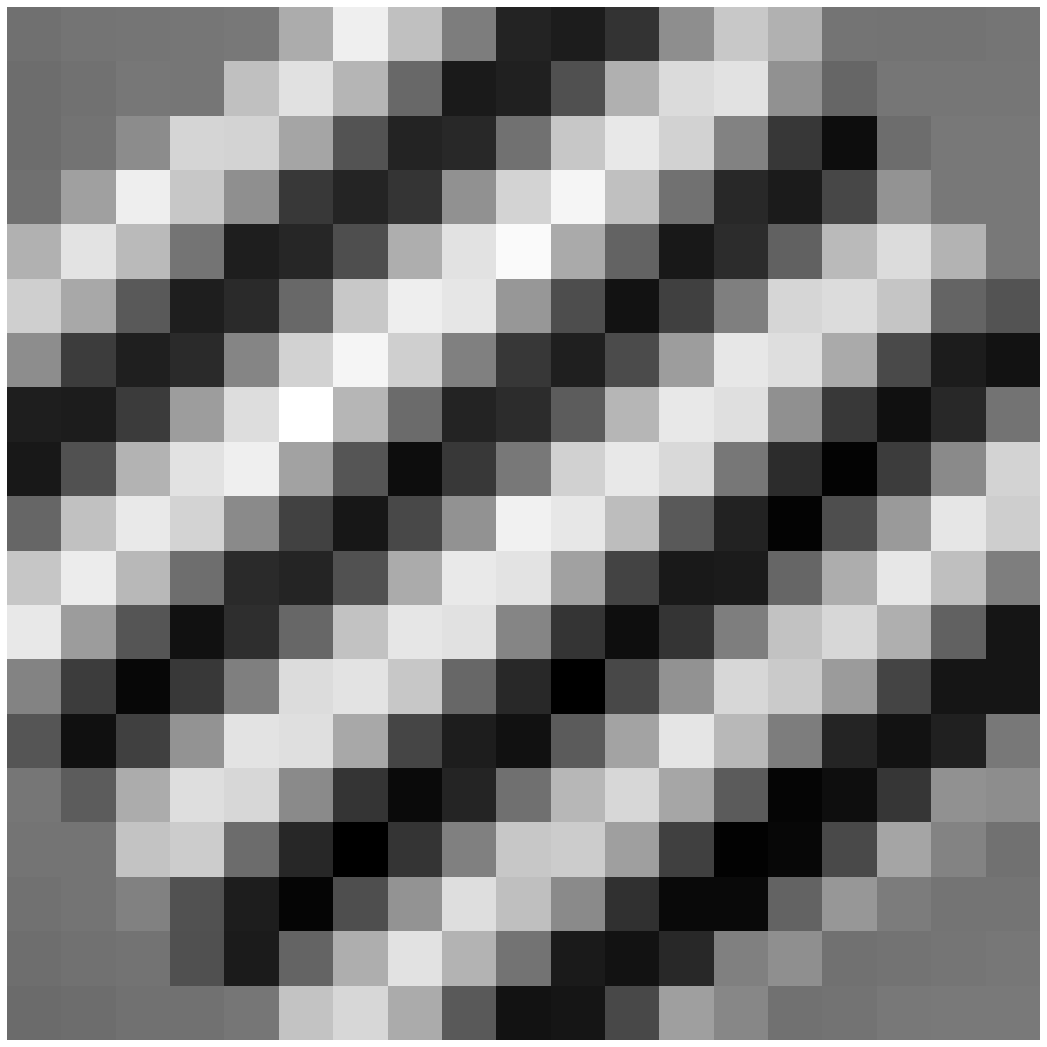

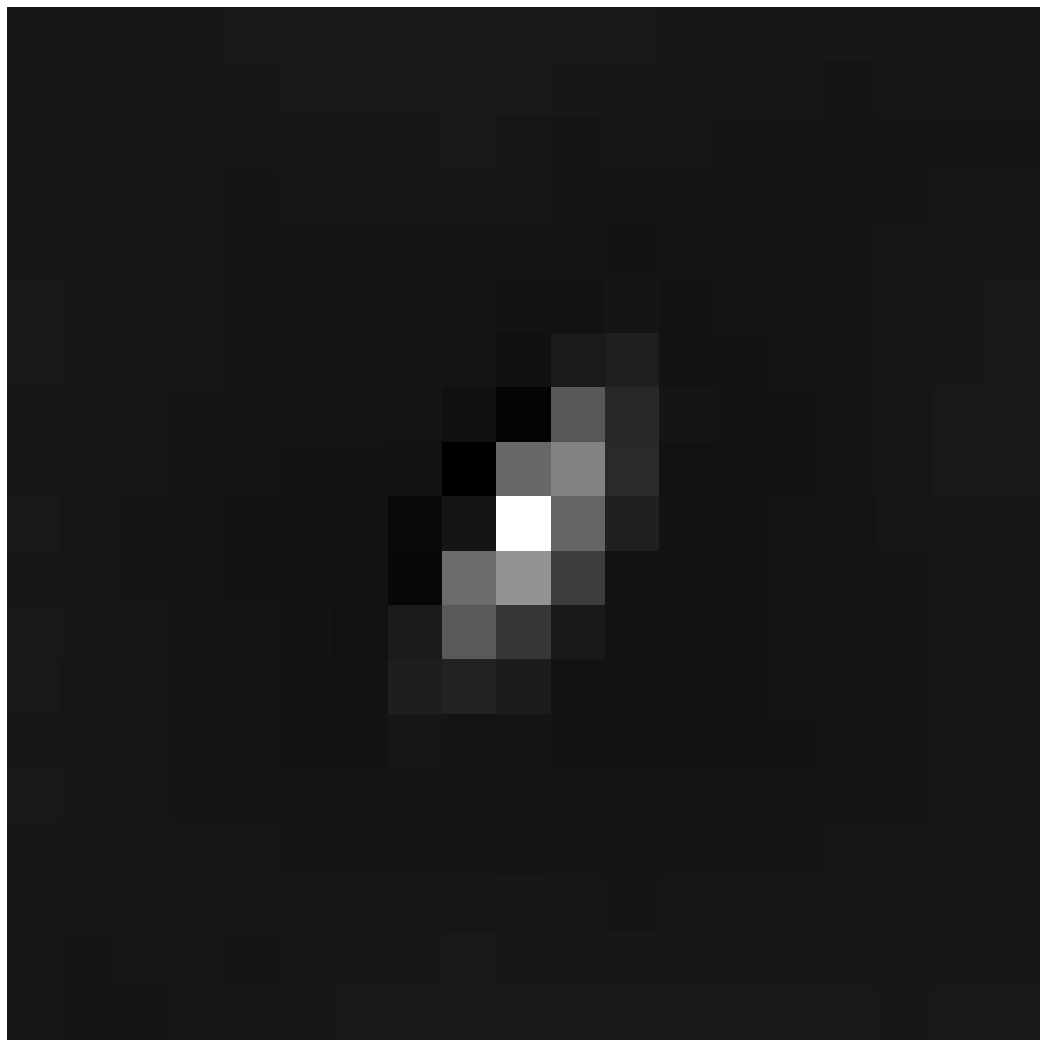

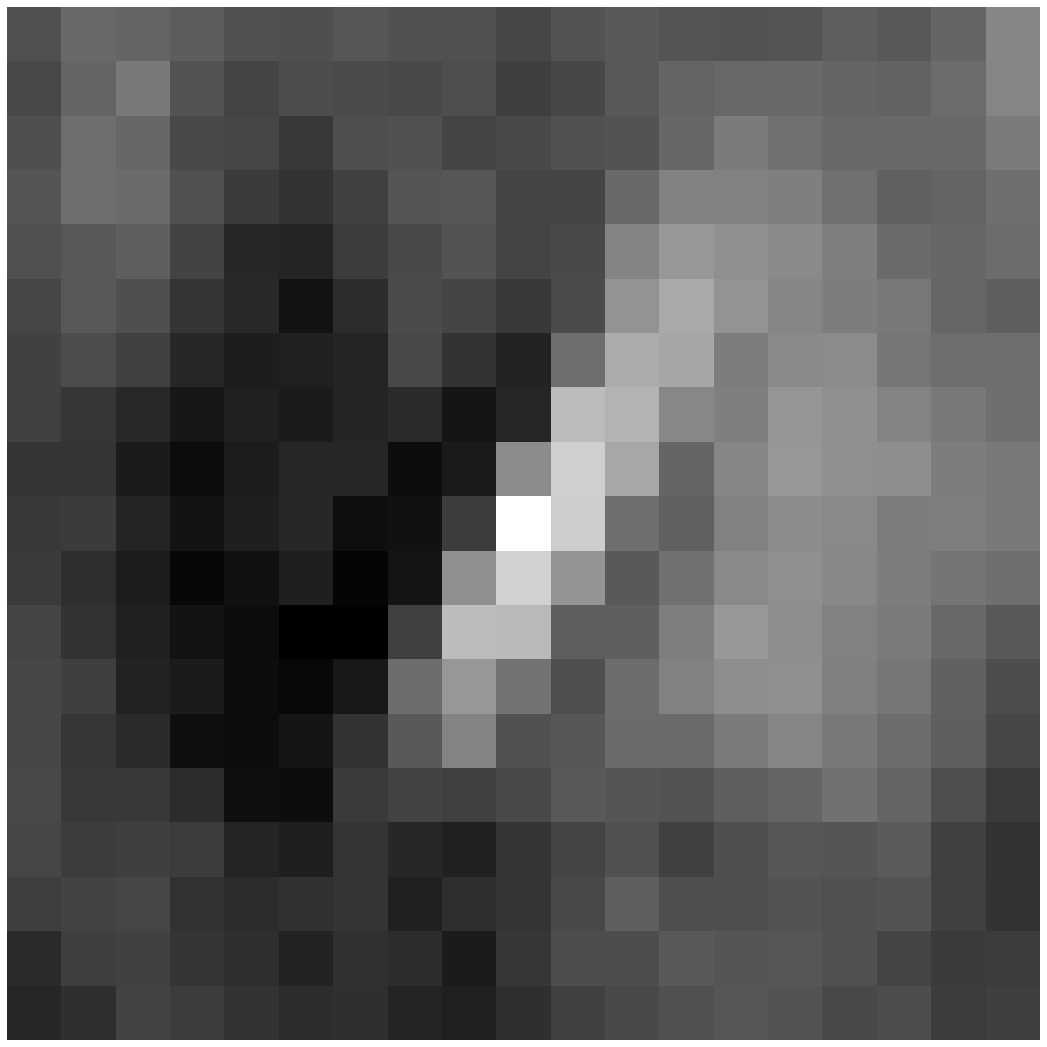

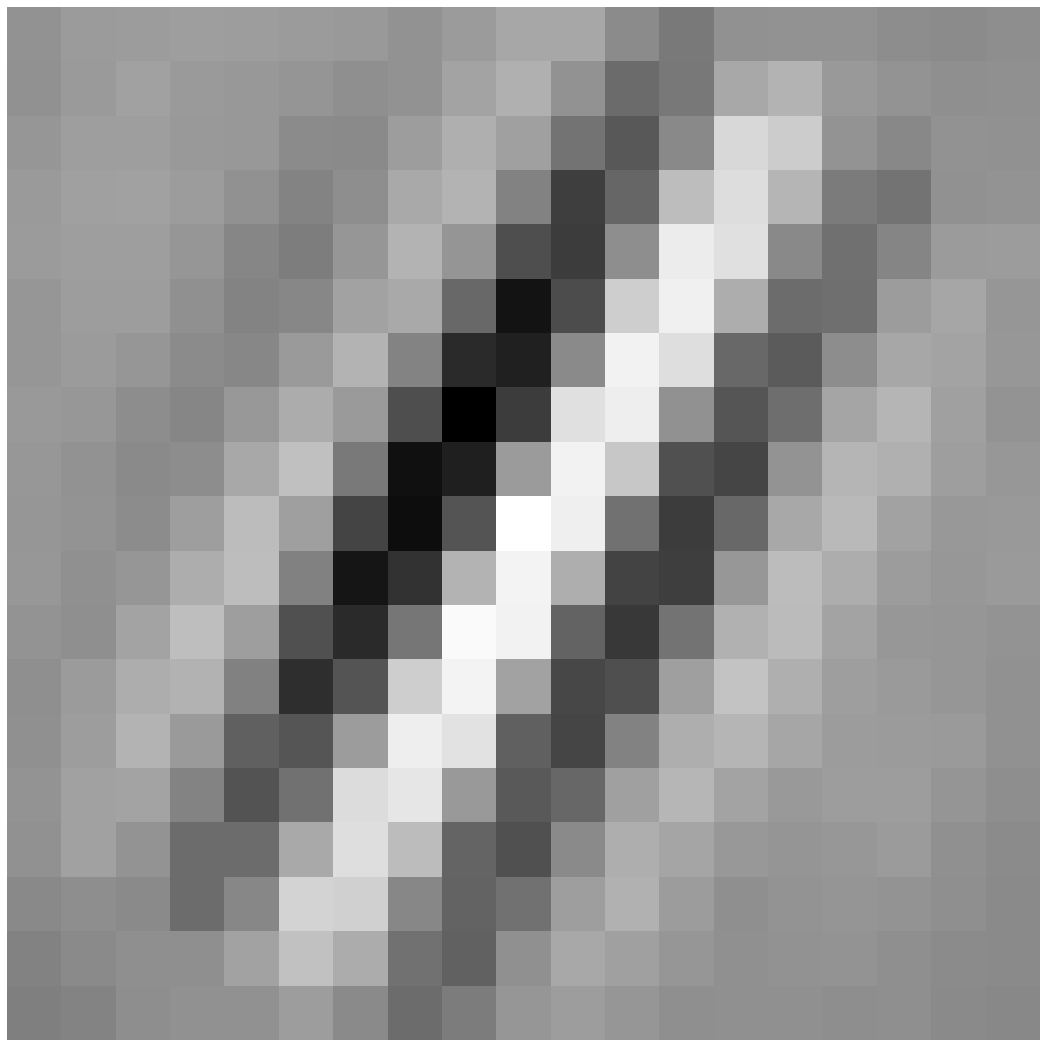

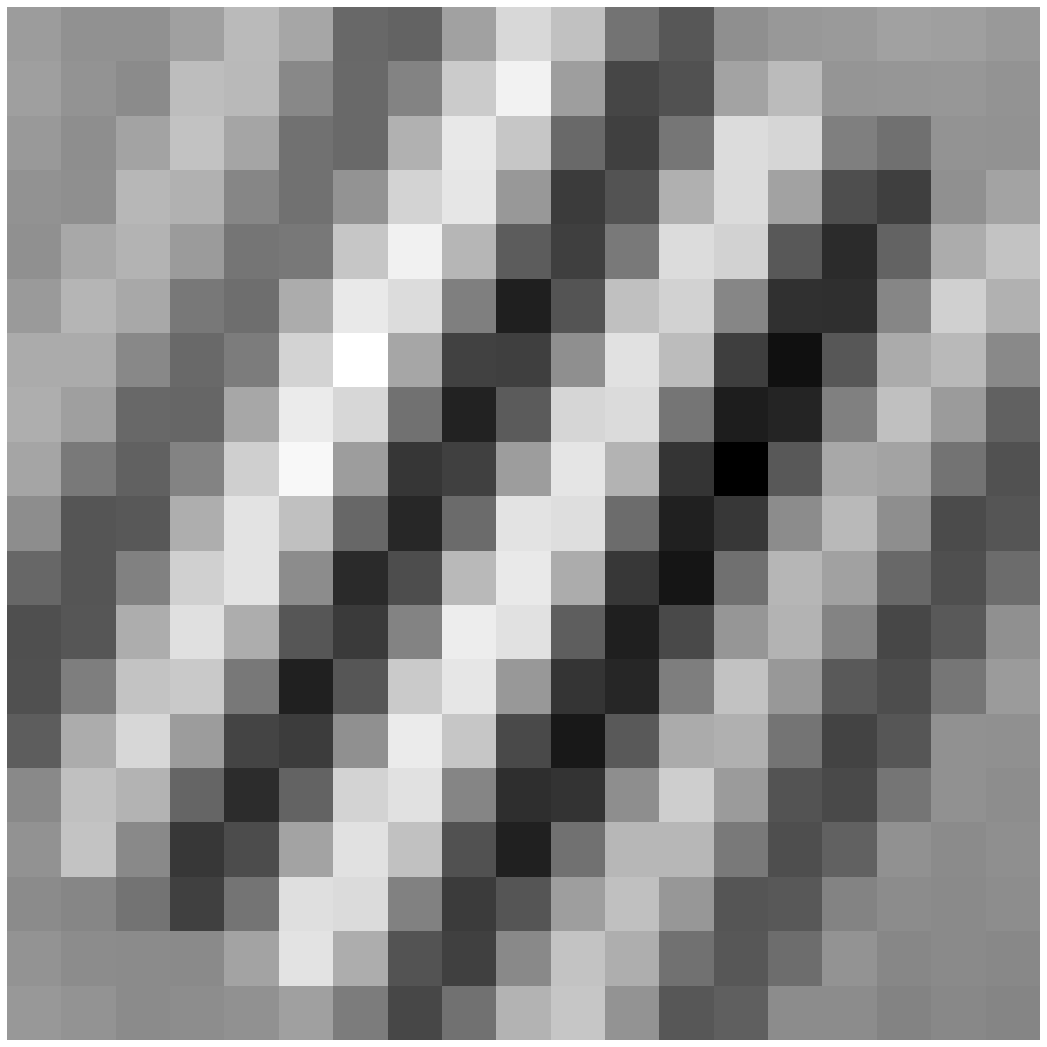

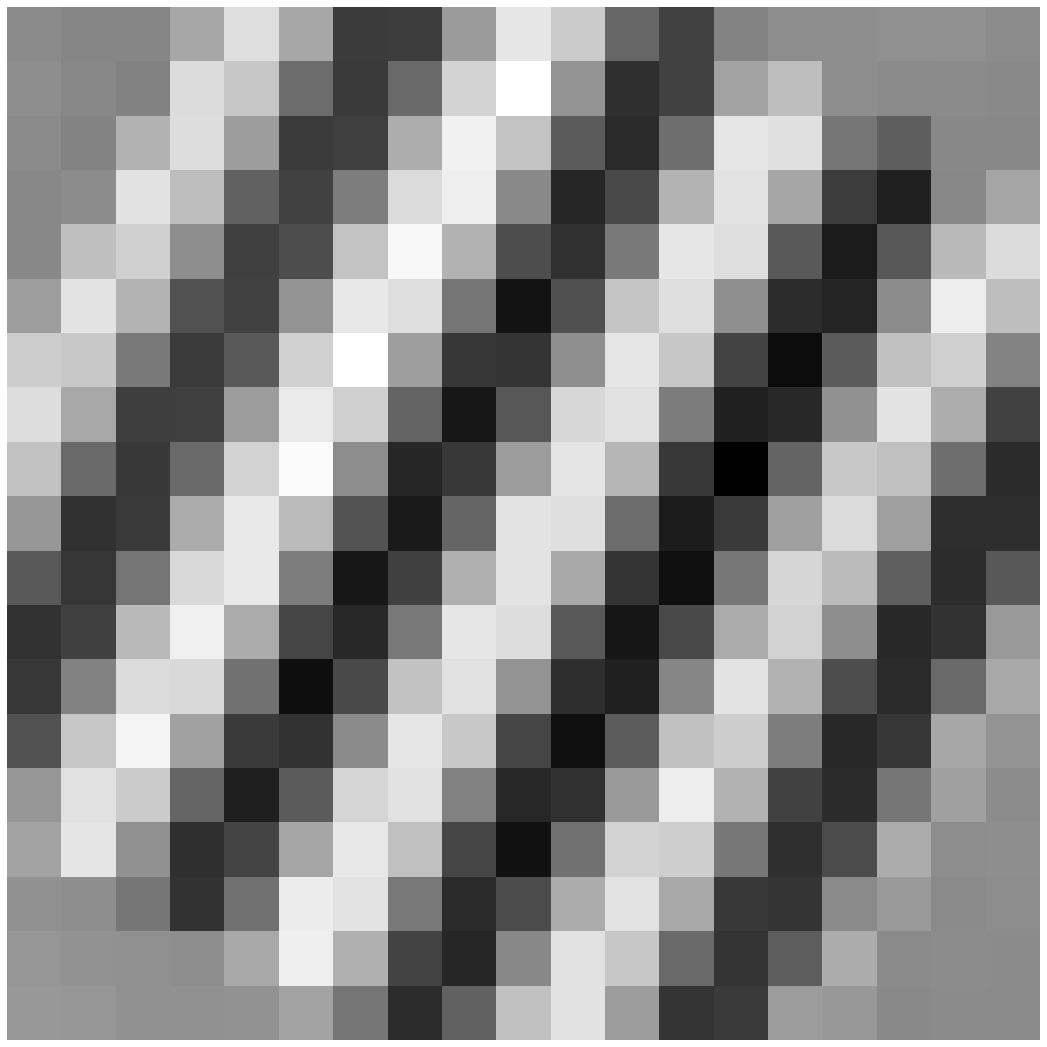

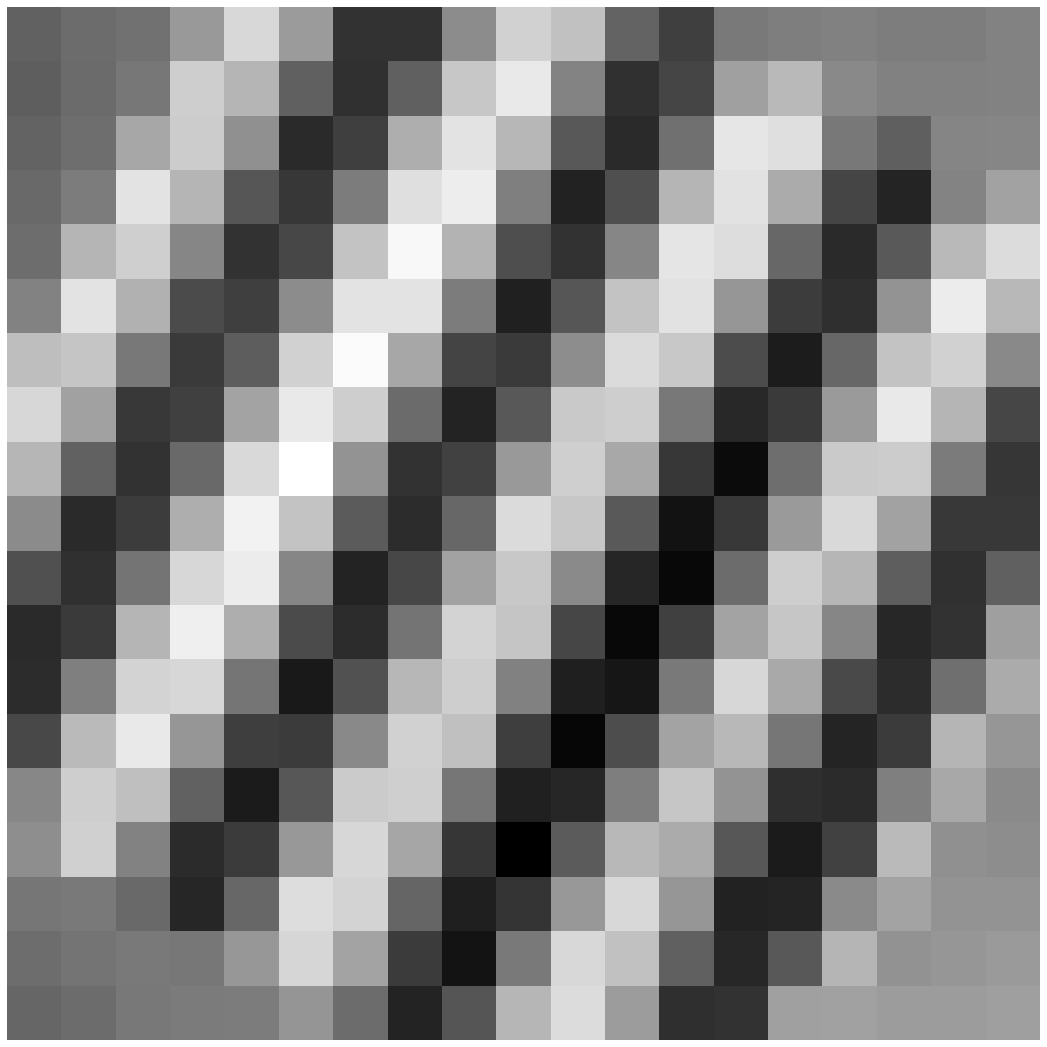

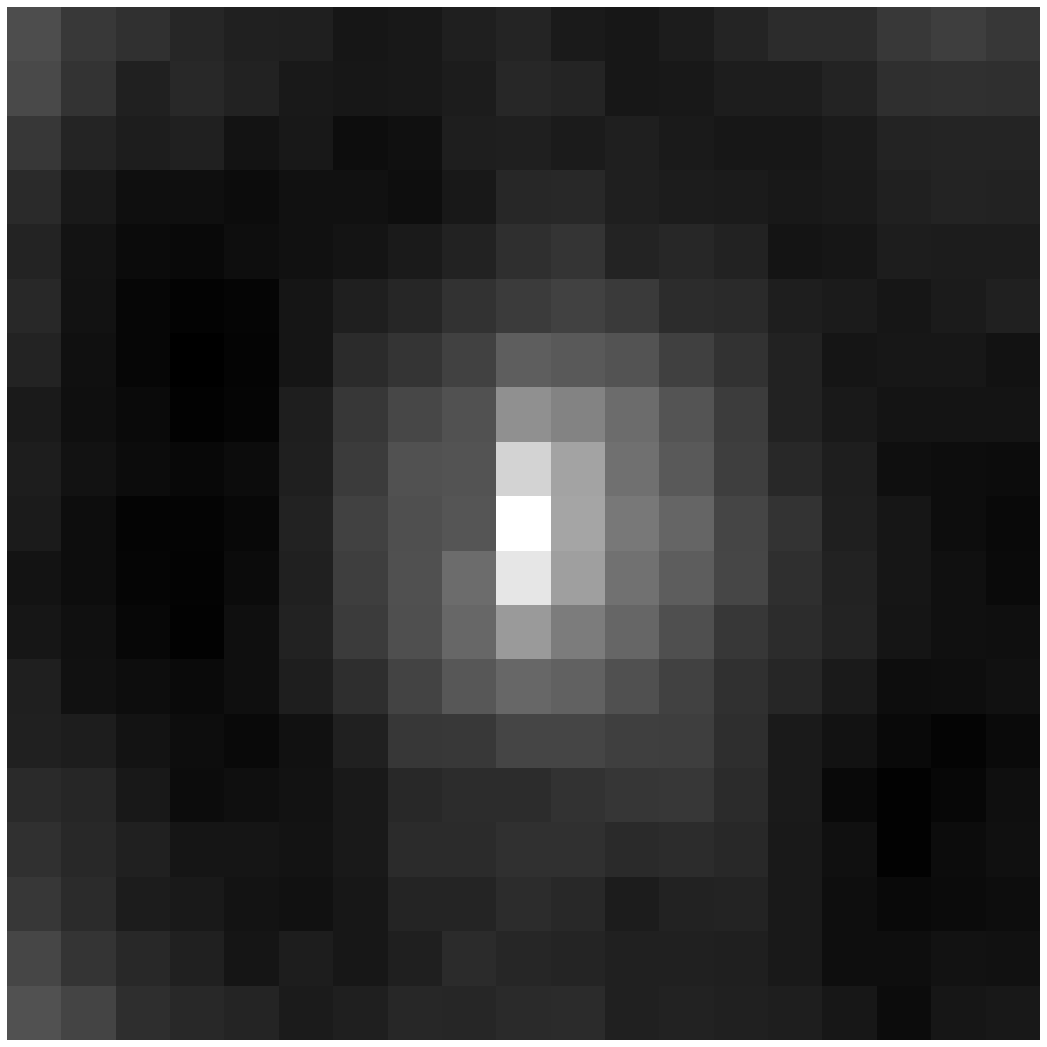

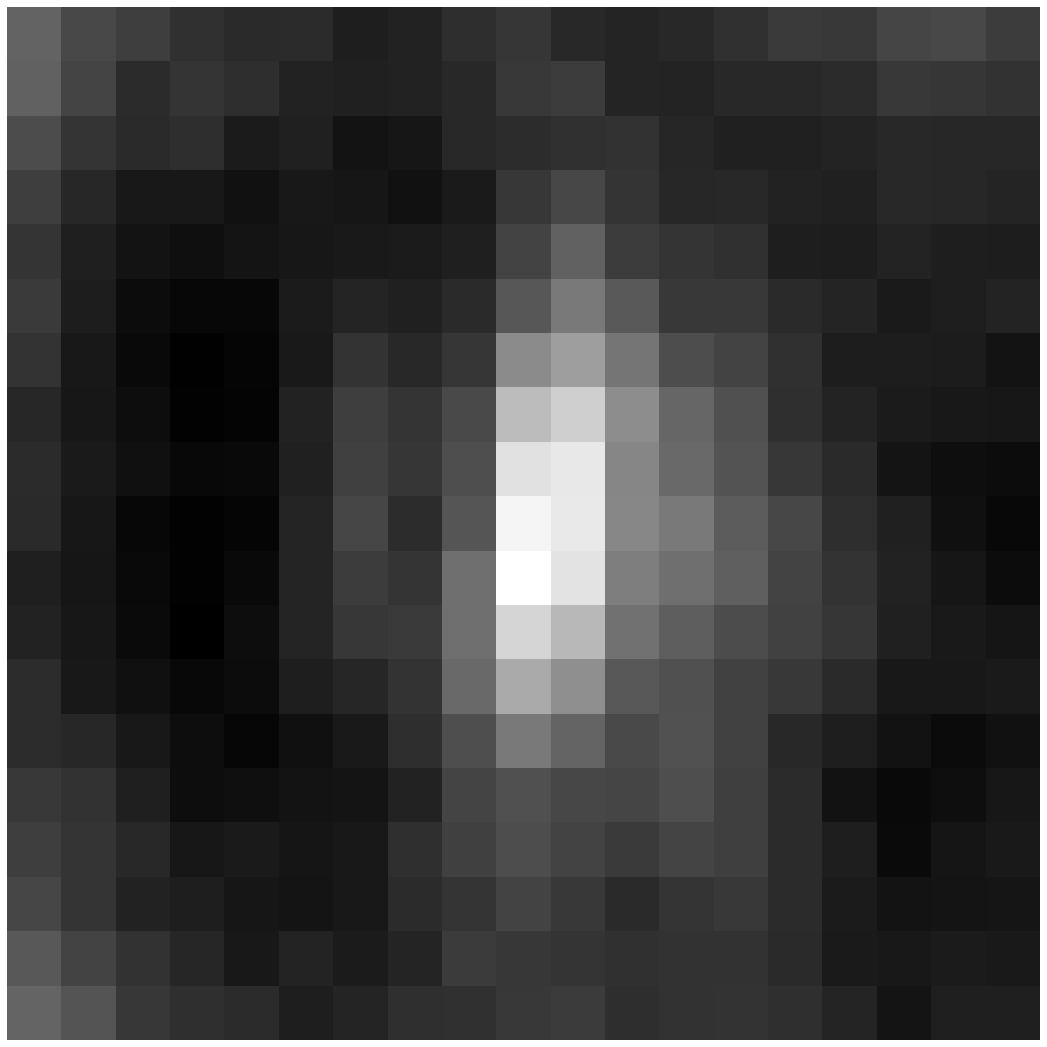

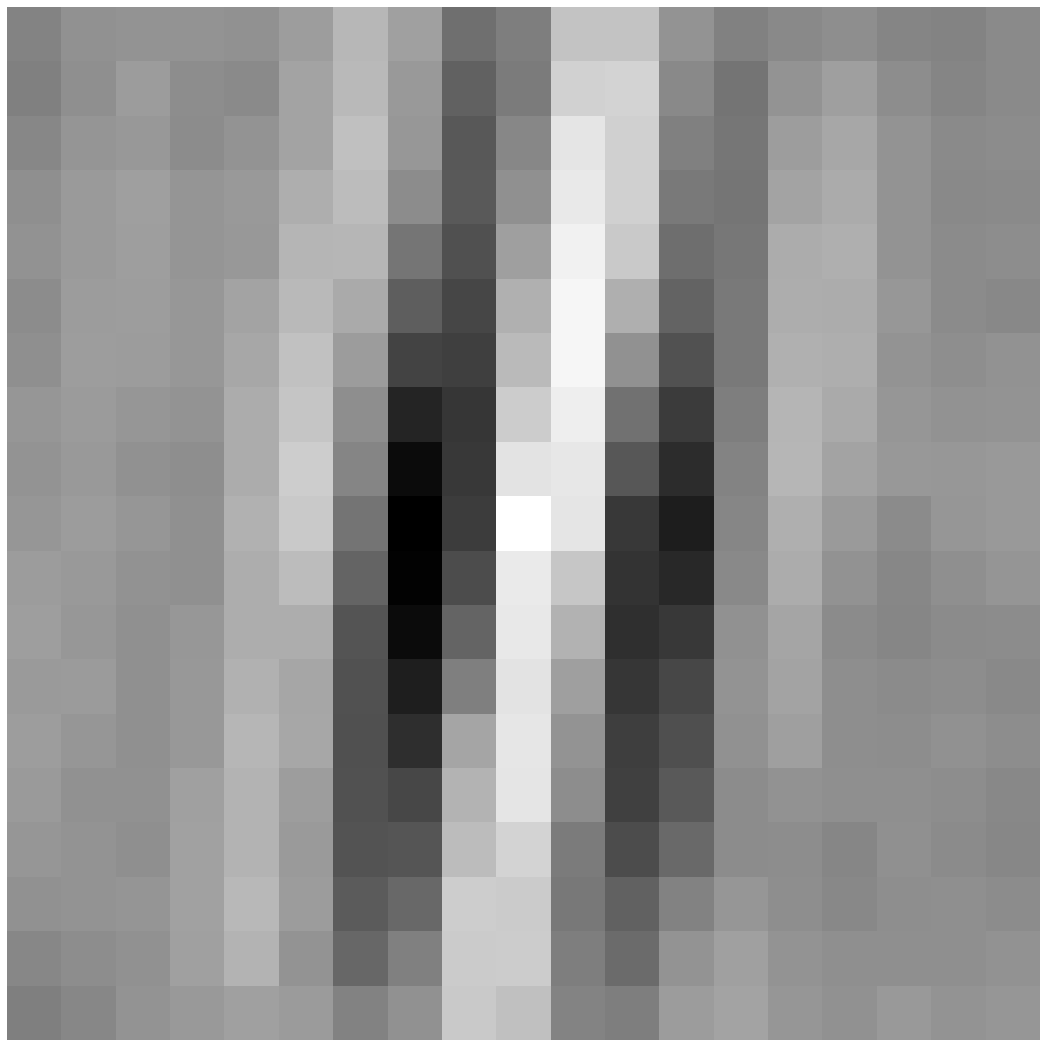

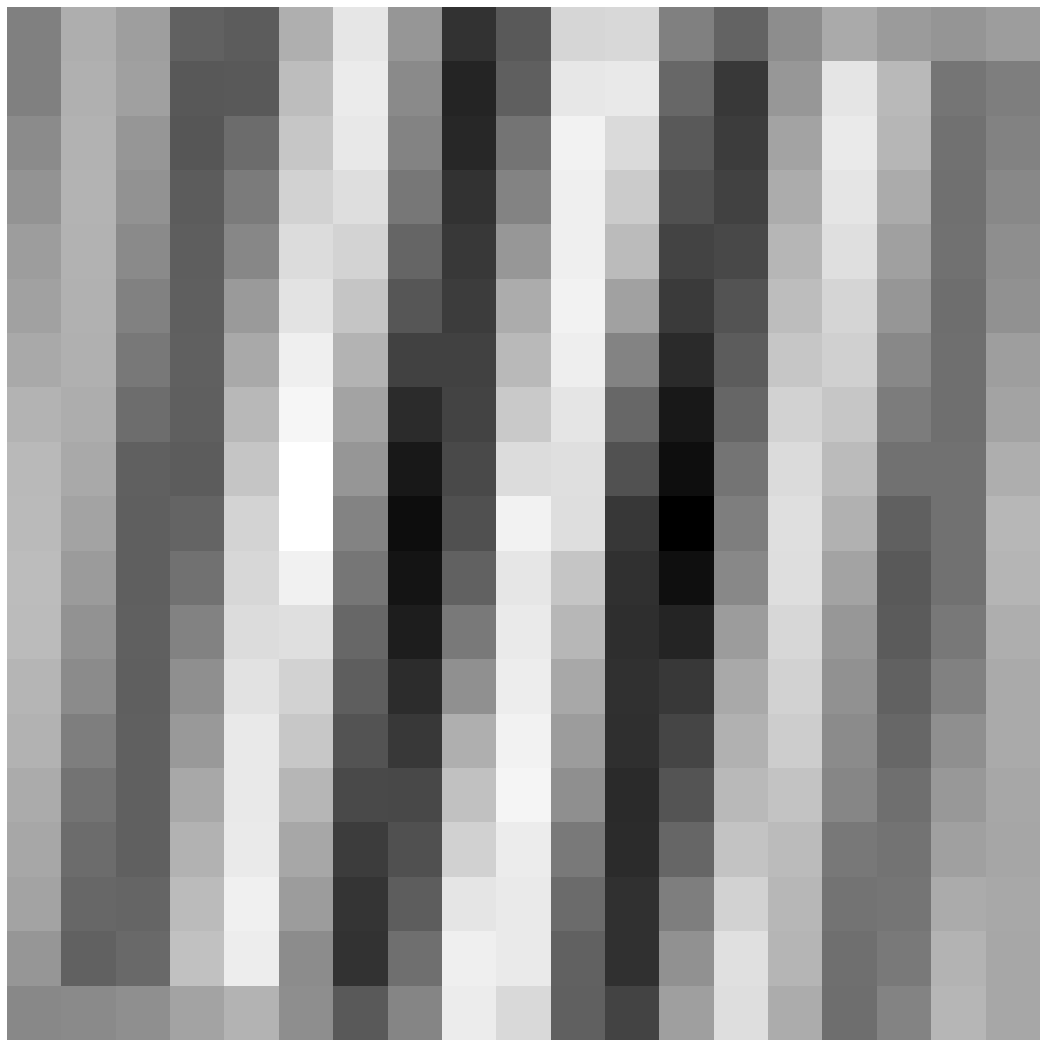

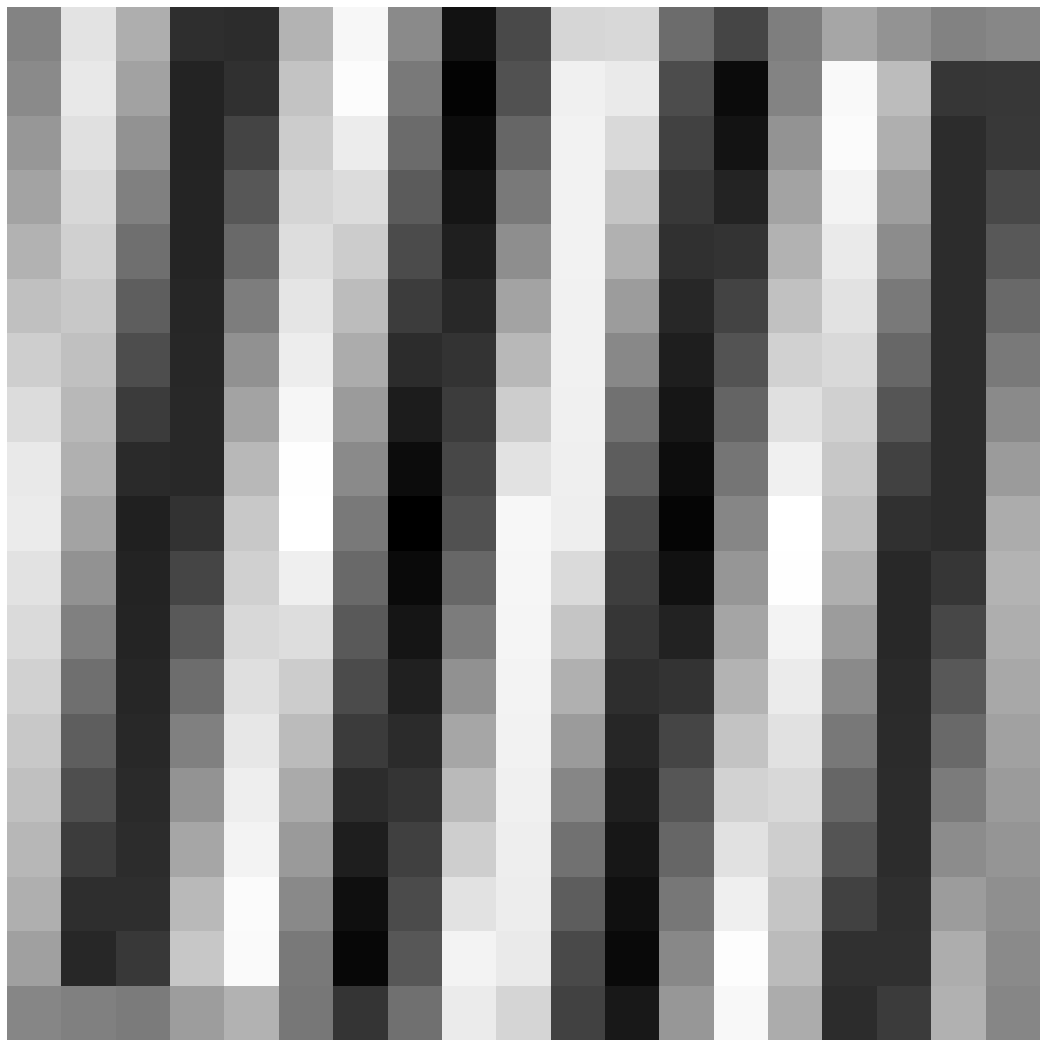

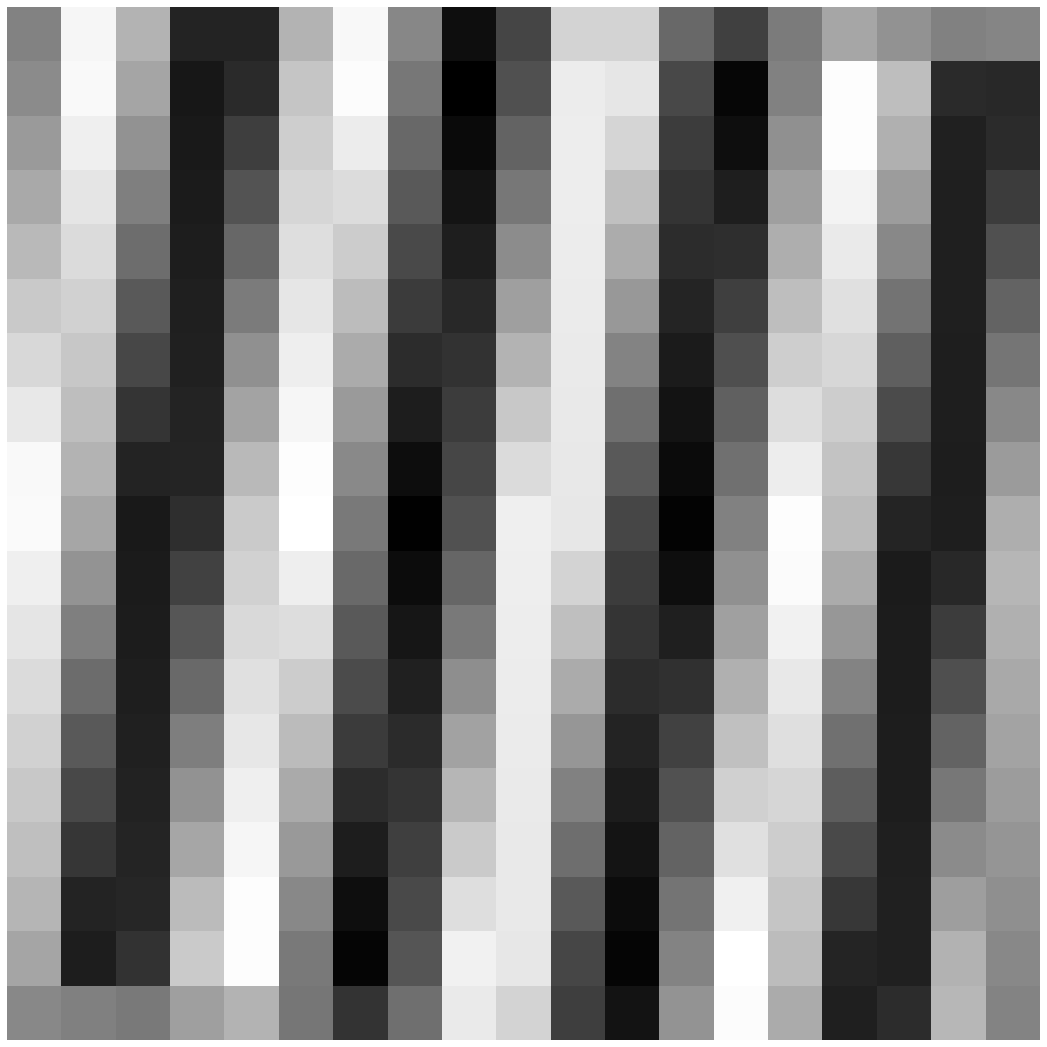

In [14]:
def myLoss(output, target):
#     print("size,size:",output.size(), target.size())
#     print("size,", ((1-2*target) * torch.log(output)).size())
#     return -torch.sum(target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)
    return -torch.sum((36885/34546)*target * torch.log(output) + (1-target) * torch.log(1-output)) / len(output)

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
#         loss = F.nll_loss(output, target)
        loss = myLoss(output[2], target)
        loss.backward(retain_graph=True)
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(args, model, device, test_loader,count,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx,(data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
#             test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            test_loss += myLoss(output[2], target)
#             pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            t = Variable(torch.Tensor([0.5]))
            pred = (output[2] > t) * 1
            pred = torch.reshape(pred, (len(target), 1))
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
             # Store wrongly predicted images
            if epoch == 9:
                wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
                wrong_samples = data[wrong_idx]
                wrong_preds = pred[wrong_idx]
                actual_preds = target.view_as(pred)[wrong_idx]
                for i in range(len(wrong_idx)):
                    sample = wrong_samples[i]
                    wrong_pred = wrong_preds[i]
                    actual_pred = actual_preds[i]
                    # Undo normalization
            #         sample = sample * 0.3081
            #         sample = sample + 0.1307
                    sample = sample * 255.
                    sample = sample.byte()
                    img = TF.to_pil_image(sample)
                    count = count+1
                    img.save('./wrong-gabor/batch{}_i{}_actual{}_pc{:.4f}.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item(),output[1][wrong_idx[i]]))
                    num = batch_idx * 64 + wrong_idx[i]
    #                 print(batch_idx,wrong_idx[i])
                    img_ori = origin_dataset[num][0].numpy()
                    plt.imsave('./wrong-gabor/batch{}_i{}_actual{}_ori.png'.format(
                    batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')
            
                
                    
                
    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1])))
    

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=512, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 0.01)')
    parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                        help='SGD momentum (default: 0.5)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    parser.add_argument('--std', type=float, default=0, metavar='STD',
                        help='noise-std (default: 0)')
    parser.add_argument('--mean', type=float, default=0, metavar='MEAN',
                        help='noise-std (default: 0)')
#     args = parser.parse_args()
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
#     transform=transforms.Compose([
#         transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
#         ])
    model = GaborConvPC(19, 1, 8, 6).to(device)
    # if torch.cuda.is_available():
    #     torch.set_default_tensor_type('torch.cuda.FloatTensor')
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
    count = 0
    for param in model.parameters():
        print(type(param.data), param.size())
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader,count,epoch)
        # for param in model.parameters():
        #     print(param.size(), param.data)
        # print(model.state_dict())
        if epoch == 9:
            print(model.sigma1, model.theta1,model.Lambda1, model.psi1, model.gamma1)
            scale = 0
            ori = 0
            for i in range(len(model.filter_cos)):
#                 sample = model.filter_cos[i]
#                 print('ori' , sample)
#                 sample = sample * 255.
#                 print('first' , sample)
#                 sample = sample.byte()
#                 print('second' , sample)
#                 img = TF.to_pil_image(sample)
                figure, b = plt.subplots()
                figure.set_size_inches(19, 19)
                plt.axis('off')
                plt.imshow(model.filter_cos[i].detach().numpy()[0], cmap='gray')
#                 np.savetxt('train-coeff.txt', model.filter_cos[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
#                 img.save('./filter/{}_ori_{}scale_{}.png'.format('cos',ori,scale))
                si = model.sigma1.detach().numpy()*(2.1**scale)
                de = model.theta1.detach().numpy()+ori*np.pi/8
                plt.savefig("./filter-11.3_9/%s_scale_%.2fdeg_%.2f.png" % ('cos',si,de), dpi=1,pad_inches=0.0,bbox_inches='tight')
                if scale == 5:
                    scale = 0
                    ori = ori+1
                else:
                    scale = scale + 1

            scale = 0
            ori = 0
            for i in range(len(model.filter_sin)):
#                 sample = model.filter_sin[i]
#                 sample = sample * 255.
#                 sample = sample.byte()
#                 img = TF.to_pil_image(sample)
                figure, b = plt.subplots()
                figure.set_size_inches(0.19, 0.19)
                plt.axis('off')
                plt.imshow(model.filter_sin[i].detach().numpy()[0], cmap='gray')
#                 np.savetxt('train-coeff.txt', model.filter_sin[i].detach().numpy()[0], delimiter='    ',fmt='%1.2f')
                si = model.sigma1.detach().numpy()*(2.1**scale)
                de = model.theta1.detach().numpy()+ori*np.pi/8
#                 img.save('./filter/{}_ori_{}scale_{}.png'.ormat('sin',ori,scale))
                plt.savefig("./filter-11.3_9/%s_scale_%.2fdeg_%.2f.png" % ('sin',si,de), dpi=100,pad_inches=0.0,bbox_inches='tight')
                if scale == 5:
                    scale = 0
                    ori = ori + 1
                else:
                    scale = scale + 1




    if (args.save_model):
        torch.save(model.state_dict(),"pretrain_gabor.pt")

if __name__ == '__main__':
    main()

In [41]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.fc1 = nn.Linear(3136, 1024)
        self.fc2 = nn.Linear(1024, 2)
        

#     def forward(self, x):
#         x = self.conv1(x)
#         x_conv1 = F.relu(x)
#         x_temp = self.conv2(x_conv1)
#         x_conv2 = F.relu(x_temp)
#         x_conv2 = F.max_pool2d(x_conv2, 2)
#         print(x_conv2.shape)
#         x_conv1 = torch.flatten(x_conv1, 1)
#         x_conv2 = torch.flatten(x_conv2, 1)
#         x_concat = torch.cat((x_conv1, x_conv2), 1)
#         x = self.fc1(x_concat)
#         x = F.relu(x)
#         x = self.fc2(x)
#         output = F.log_softmax(x, dim=1)
#         return output
    def forward(self, x_ori):
        x = self.conv1(x_ori)
        conv1 = F.relu(x)  #store conv1
        conv2 = self.conv2(conv1)
        conv2 = F.relu(conv2) #store conv2
        x = F.max_pool2d(conv2, 2)
#         x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
#         x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output,x_ori,conv1,conv2


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    num = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        weight = torch.tensor([34546/(36885+34546),36885/(36885+34546)])
        loss = F.nll_loss(output[0], target, weight = weight)
        loss.backward()
        optimizer.step()
        if epoch == 3 and batch_idx == 10:
            for i in range(64):
                img_ori = output[1][i].numpy()
                real = target[i].detach().numpy()
                predict = output[0][i].detach().numpy()
                plt.imsave('./CNN/real{}_{}_a.png'.format(real,num),img_ori[0],cmap = 'gray')
                img_conv1 = output[2][i].detach().numpy()
                for j in range(len(img_conv1)):
                    plt.imsave('./CNN/real{}_{}_conv1_{}.png'.format(real, num, j),img_conv1[0],cmap = 'gray')
                img_conv2 = output[3][i].detach().numpy()
                for k in range(len(img_conv2)):
                    plt.imsave('./CNN/real{}_{}_conv2_{}.png'.format(real,num,k),img_conv2[0],cmap = 'gray')
                num = num+1
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))

            if args.dry_run:
                break
                


def test(model, device, test_loader,count,epoch):
    model.eval()
    test_loss = 0
    correct = 0
    result= [[0,0], [0,0]] 
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output[0], target, reduction='sum').item()  # sum up batch loss
            pred = output[0].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            cmat = confusion_matrix(target.view_as(pred), pred, labels=[0, 1]) 
            result = [[result[i][j] + cmat[i][j]  for j in range(len(result[0]))] for i in range(len(result))] 
            
            # Store wrongly predicted images
            wrong_idx = (pred != target.view_as(pred)).nonzero()[:, 0]
            wrong_samples = data[wrong_idx]
            wrong_preds = pred[wrong_idx]
            actual_preds = target.view_as(pred)[wrong_idx]
            for i in range(len(wrong_idx)):
                sample = wrong_samples[i]
                wrong_pred = wrong_preds[i]
                actual_pred = actual_preds[i]
                # Undo normalization
        #         sample = sample * 0.3081
        #         sample = sample + 0.1307
                sample = sample * 255.
                sample = sample.byte()
                img = TF.to_pil_image(sample)
                count = count+1
                img.save('./wrong/epoch{}_batch{}_idx{}_actual{}.png'.format(
                epoch,batch_idx,wrong_idx[i], actual_pred.item()))
                num = batch_idx * 64 + wrong_idx[i]
                img_ori = origin_dataset[num][0].numpy()
                plt.imsave('./wrong/epoch{}_batch{}_idx{}_actual{}_ori.png'.format(
                epoch,batch_idx,wrong_idx[i], actual_pred.item()), img_ori[0], cmap = 'gray')

    test_loss /= len(test_loader.dataset)
    precision = result[1][1]/(result[1][1]+result[0][1])
    recall = result[0][0]/(result[0][0]+result[1][0])
    f1score = 2*(precision*recall)/(precision+recall)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Positive accuracy: {}/{} ({:.0f}%), Negative accuracy: {}/{} ({:.0f}%), f1 score: {:.4f}\n'.format(
        test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset), 
        result[1][1],result[1][1]+result[1][0],100. * result[1][1]/(result[1][1]+result[1][0]),
        result[0][0],result[0][0]+result[0][1],100. * result[0][0]/(result[0][0]+result[0][1]),f1score))


def main():
    # Training settings
    parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    parser.add_argument('--batch-size', type=int, default=64, metavar='N',
                        help='input batch size for training (default: 64)')
    parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                        help='input batch size for testing (default: 1000)')
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 14)')
    parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                        help='learning rate (default: 1.0)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
                        help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,
                        help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=100, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,
                        help='For Saving the current Model')
    args, unknown = parser.parse_known_args()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'batch_size': args.batch_size}
    if use_cuda:
        kwargs.update({'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True},
                     )

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)
    count = 0
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader, count, epoch)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


if __name__ == '__main__':
    main()

Train Epoch: 1 [0/71432 (0%)]	Loss: 0.686289
Train Epoch: 1 [6400/71432 (9%)]	Loss: 0.584539
Train Epoch: 1 [12800/71432 (18%)]	Loss: 0.474190
Train Epoch: 1 [19200/71432 (27%)]	Loss: 0.402076
Train Epoch: 1 [25600/71432 (36%)]	Loss: 0.370735
Train Epoch: 1 [32000/71432 (45%)]	Loss: 0.283491
Train Epoch: 1 [38400/71432 (54%)]	Loss: 0.276498
Train Epoch: 1 [44800/71432 (63%)]	Loss: 0.240855
Train Epoch: 1 [51200/71432 (72%)]	Loss: 0.227262
Train Epoch: 1 [57600/71432 (81%)]	Loss: 0.276971
Train Epoch: 1 [64000/71432 (90%)]	Loss: 0.208923
Train Epoch: 1 [70400/71432 (98%)]	Loss: 0.153050

Test set: Average loss: 0.2378, Accuracy: 7417/8088 (92%), Positive accuracy: 3994/4089 (98%), Negative accuracy: 3423/3999 (86%), f1 score: 0.9208

Train Epoch: 2 [0/71432 (0%)]	Loss: 0.306779
Train Epoch: 2 [6400/71432 (9%)]	Loss: 0.264262
Train Epoch: 2 [12800/71432 (18%)]	Loss: 0.205650
Train Epoch: 2 [19200/71432 (27%)]	Loss: 0.160425
Train Epoch: 2 [25600/71432 (36%)]	Loss: 0.156365
Train Epoch: 2